# ACDC 3D Segmentation

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2023-06-19 16:17:57.367932: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-19 16:18:01.038628: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 16:18:13.561805: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
#!pip freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip install --upgrade --user

In [4]:
!pip install -q --upgrade --user torch-lr-finder --global-option="apex"

# Install all dependencies
!pip install -q \
            monai \
            nibabel \
            torch \
            wandb \
            focal-loss \
            matplotlib \
            numpy \
            pandas \
            seaborn \
            tqdm

# Install a specific version of PyTorch in jupyterlab matching the Cuda installed version
# !pip install torch==1.13.1+cu116 torchvision==0.14.1+cu116 torchaudio -f https://download.pytorch.org/whl/torch_stable.html

DEPRECATION: --build-option and --global-option are deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859
Defaulting to user installation because normal site-packages is not writeable
  Using cached protobuf-3.19.6-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.


## Setup imports

In [1]:
import gc
import glob
import matplotlib.pyplot as plt
import monai
import numpy as np
import os
import pandas as pd
import shutil
import tempfile
import time
import torch
import wandb
from datetime import datetime
from focal_loss.focal_loss import FocalLoss
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.handlers.utils import from_engine
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceFocalLoss
from monai.metrics import DiceMetric
from monai.networks.layers import Norm
from monai.networks.nets import UNet, SegResNet, SwinUNETR
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    Compose,
    CropForegroundd,
    DivisiblePadd,
    EnsureChannelFirstd,
    EnsureTyped,
    Invertd,
    Lambda,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandCropByPosNegLabeld,
    ResizeWithPadOrCropd,
    SaveImaged,
    ScaleIntensityRanged,
    ScaleIntensityd,
    Spacingd,
)
from monai.utils import first, set_determinism
from nibabel import nib
from pprint import pprint
from scipy import ndimage
from scipy.ndimage import binary_dilation, binary_erosion, generate_binary_structure, label, ndi_sum
from torch_lr_finder import LRFinder
from torch_lr_finder.lr_finder import DataLoaderIter, ValDataLoaderIter
from torch.nn import init
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.autonotebook import tqdm
from typing import Dict, List
import seaborn as sns


set_determinism(seed=0)  # Set deterministic seed for training reproducability

print_config()

MONAI version: 1.3.dev2325
Numpy version: 1.23.1
Pytorch version: 1.13.1+cu116
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: b6f261f5053a04ef11bede75465cb581e60cf26f
MONAI __file__: /home/jovyan/.local/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 10.0.0
Tensorboard version: 2.11.2
gdown version: 4.7.1
TorchVision version: 0.14.1+cu116
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.5
pandas version: 2.0.3
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.4.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
def delete_files_in_directory(directory_path):
    """
    Delete all files and directories in a given directory.

    Parameters:
    directory_path (str): The path of the directory to be cleaned.

    Returns:
    None
    """
    if not os.path.isdir(directory_path):
        return

    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))


def load_images(base_dir, directory_name):
    """
    Load all image and label file paths from a given directory.

    Parameters:
    base_dir (str): The base directory.
    directory_name (str): The name of the directory to load images from, relative to the base directory.

    Returns:
    list: A list of dictionaries, each containing an image file path and corresponding label file path, 
    or only an image file path if no label file is present.
    """
    datadirectory = os.path.join(base_dir, directory_name)

    images_path = sorted(glob.glob(os.path.join(datadirectory, '**', "patient*_frame??.nii.gz")))
    labels_path = sorted(glob.glob(os.path.join(datadirectory, '**', "patient*_frame??_gt.nii.gz")))

    if labels_path:
        data_dicts = [{"image": image_name, "label": label_name}
                      for image_name, label_name in zip(images_path, labels_path)]
    else:
        # If there are no label files, only return the image paths.
        data_dicts = [{"image": image_name} for image_name in images_path]

    return data_dicts


def calculate_mean_area(loader):
    """
    Calculate the mean area, weighted mean area, and loss weights for a given image loader.

    Parameters:
    loader (DataLoader): The image loader for which to calculate the mean area, weighted mean area, and loss weights.

    Returns:
    dict: A dictionary containing the mean area, weighted mean area, and scaled loss weights for each class.
    """
    count_total = torch.zeros(4)
    count_images = 0

    for batch in loader:
        image, label = batch['image'], batch['label']

        count_images += image.shape[0]

        for i in range(4):  # assuming 4 classes
            count_total[i] += (label == i).sum().item()

    # Calculate the mean area by dividing the total count by the number of images
    mean_areas = count_total / count_images

    # Calculate the weighted mean area
    weighted_mean_areas = count_total / torch.sum(count_total)

    # Calculate the loss weights
    total_area = torch.sum(count_total)
    loss_weights = total_area / (4 * count_total)

    # Scale loss weights to [0, 1]
    loss_weights = loss_weights / torch.max(loss_weights)

    return {
        "mean_area": mean_areas,
        "weighted_mean_area": weighted_mean_areas,
        "loss_weights": loss_weights
    }


## Setup data directory

In [6]:
###
# Set the data path & load images
###

base_dir = os.path.join(os.getcwd(), "./data/ACDC/database")

train_files = load_images(base_dir, 'training')
val_files = load_images(base_dir, 'testing')
secret_files = load_images(base_dir, 'secret')

print(f"Training Size: {len(train_files)}")
print(f"Validation Size: {len(val_files)}")
print(f"Secret Size: {len(secret_files)}")

In [8]:
###
# Print image metadata when needed
###

def print_metadata():
    nifti_data = nib.load(train_files[0]['image'])
    nifti_data = nib.load(secret_files[0]['image'])

    # Access the metadata attributes of the NIfTI file
    metadata = nifti_data.header

    # Print or manipulate the metadata as desired
    print(metadata)

# print_metadata()

In [9]:
###
# Data pipeline classes
###


class ACDCDataset(Dataset):
    """
    Dataset for handling ACDC images and labels. 
    This dataset allows to limit the number of augmentations per unique image.

    Args:
        image_dir (str): The directory path that contains the image files.
        label_dir (str): The directory path that contains the label files.
        max_augmentations_per_image (int, optional): Maximum number of augmentations to load per unique image. Defaults to None.
        mode (str, optional): Mode to return the data ("normal" returns tuple, "monai" returns dict). Defaults to "monai".
    """

    def __init__(self, image_dir, label_dir, max_augmentations_per_image=None, mode="monai"):
        self.mode = mode
        self.max_augmentations_per_image = max_augmentations_per_image

        all_image_paths = sorted(glob.glob(f"{image_dir}/*.npy"))

        self.image_paths = []
        self.augmentation_counts = {}

        # Filter image paths based on max_augmentations_per_image
        for image_path in all_image_paths:
            img_idx = int(image_path.split('_')[-2].split('-')[-1])

            # If max augmentations not reached, add to image paths
            if img_idx not in self.augmentation_counts or (self.max_augmentations_per_image is not None and self.augmentation_counts[img_idx] < self.max_augmentations_per_image):
                self.image_paths.append(image_path)
                if img_idx in self.augmentation_counts:
                    self.augmentation_counts[img_idx] += 1
                else:
                    self.augmentation_counts[img_idx] = 1

        # Create corresponding label paths
        self.label_paths = [
            x.replace("images", "labels").replace("image", "label")
            for x in self.image_paths]

    def __len__(self):
        """Returns the number of image-label pairs in the dataset."""
        return len(self.image_paths)

    def get_file(self, idx):
        """Returns the file paths of the image-label pair at the specified index."""
        if self.mode == "normal":
            return (self.image_paths[idx], self.label_paths[idx])

        return {"image": self.image_paths[idx], "label": self.label_paths[idx]}

    def __getitem__(self, idx):
        """
        Returns the image-label pair at the specified index. 
        The images and labels are loaded from .npy files and converted to PyTorch tensors.

        Args:
            idx (int): Index of the image-label pair to return.

        Returns:
            dict: A dictionary containing the image and label tensors.
        """
        image = np.load(self.image_paths[idx])
        label = np.load(self.label_paths[idx])

        return {"image": torch.from_numpy(image), "label": torch.from_numpy(label)}


class ConvertToMultiChannelBasedOnClassesd(MapTransform):
    """
    Transform to one hot encode the labels into different channels
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # label 1
            result.append(d[key] == 1)
            # label 2
            result.append(d[key] == 2)
            # label 3
            result.append(d[key] == 3)
            d[key] = torch.stack(result, axis=0).float()
        return d


class SelectFirstItem(MapTransform):
    """
    Select the first item from a 4D array, to only select the first scan over time.
    """

    def __call__(self, data):
        if isinstance(data, dict):
            for key in data.keys():
                if isinstance(data[key], torch.Tensor):
                    data[key] = data[key][:1]

        return data


class KeepLargestConnectedComponent(MapTransform):
    def __init__(self, keys, applied_labels=None, independent=True, max_distance=0):
        super().__init__(keys)
        self.applied_labels = applied_labels
        self.independent = independent
        self.max_distance = max_distance

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            if self.applied_labels is None:
                # If applied_labels is None, consider all classes except the background.
                # Assume the background class is the one with the most positive labels.
                class_sums = d[key].sum(dim=[1, 2, 3])
                background_class = class_sums.argmax()
                self.applied_labels = [i for i in range(d[key].shape[0]) if i != background_class]

            if self.independent:
                for label_idx in self.applied_labels:
                    data = self.process(d[key][label_idx, ...])
                    d[key][label_idx, ...] = data
            else:
                merged_data = torch.sum(torch.stack([d[key][idx, ...] for idx in self.applied_labels]), dim=0)
                largest_component = self.process(merged_data)

                for label_idx in self.applied_labels:
                    # Assign the identified largest component back to the original corresponding labels
                    d[key][label_idx, ...] = (d[key][label_idx, ...] * largest_component.to(d[key].device))
        return d

    def process(self, data):
        if data.device.type == 'cuda':
            data = data.detach().cpu()

        data_np = data.numpy()

        if self.max_distance > 0:
            structure = generate_binary_structure(data_np.ndim, 1)
            data_np = binary_dilation(data_np, structure=structure, iterations=self.max_distance)

        # Process each 2D slice separately
        slices = []
        for z in range(data_np.shape[-1]):
            slice_np = data_np[:, :, z]
            labeled_array, num_features = label(slice_np)
            if num_features > 0:
                largest_label_idx = ndi_sum(slice_np, labeled_array, index=range(num_features + 1)).argmax()
                slice_np = (labeled_array == largest_label_idx)
            slices.append(slice_np)

        # Stack the processed slices back into a 3D volume
        data_np = np.stack(slices, axis=-1)

        return torch.from_numpy(data_np).float()


class DataLoaderLRFinder(torch.utils.data.DataLoader):
    """
    This class maps the Monai dictionary based image loader to a tuple based image loader.
    """
    def __init__(self, data, device="cuda:0", name="Loader", log=False, **kwargs): 
        super().__init__(data, **kwargs)
        self.device = device
        self.name = name
        self.log = log
        self.counter = 0

    def inputs_labels_from_batch(self, batch_data):
        inputs = batch_data["image"].to(self.device)
        labels = batch_data["label"].to(self.device)
        return inputs, labels

    def __iter__(self):
        self._iterator = super().__iter__()
        return self

    def __next__(self):
        if self.log:
            self.counter += 1
            print(f"{self.name} - {self.counter}")
        try:
            batch = next(self._iterator)
        except StopIteration:
            raise StopIteration

        return self.inputs_labels_from_batch(batch)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `EnsureChannelFirstd` ensures the original data to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [10]:
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    ResizeWithPadOrCropd,
    MapTransform,
    EnsureTyped,
    ScaleIntensityd,
    DivisiblePadd,
    Lambda,
    NormalizeIntensityd,
    RandRotate90d,
    RandFlipd,
    RandZoomd,
    RandAffined,
    ToDevice,
    EnsureType,
    RandGaussianSmoothd,
    RandHistogramShiftd,
    OneOf,
    RandGaussianNoised,
    KeepLargestConnectedComponentd,
    Activationsd,
)

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", 'label']),

        Orientationd(keys=["image", "label"], axcodes="LAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=(240, 240, 32), mode='symmetric'),

        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.9,
            spatial_size=(240, 240, 32),
            rotate_range=(np.pi/32, np.pi/32, np.pi/2),
            scale_range=(0.2, 0.2, 0.2),
            lazy=True,
            padding_mode="zeros"
        ),

        ScaleIntensityd(
            keys=["image"],
            minv=0.0,
            maxv=1.0,
        ),

        # Either add Gaussian noise or Gaussian smoothing
        OneOf([
            RandGaussianNoised(keys=['image'], prob=0.4, mean=0, std=0.1),  # Add Gaussian noise with mean=0, std=0.1
            RandGaussianSmoothd(keys=['image'], prob=0.4, sigma_x=(0.25, 0.5), sigma_y=(0.25, 0.5), sigma_z=(0.25, 0.5)),
        ], weights=[0.5, 0.5]),
        RandHistogramShiftd(keys=['image'], num_control_points=4, prob=0.3),
    ]
)


val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureTyped(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image",'label']),

        Orientationd(keys=["image", "label"], axcodes="LAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ResizeWithPadOrCropd(keys=['image', 'label'], spatial_size=(240, 240, 32), mode='symmetric'),
        ScaleIntensityd(
            keys=["image"],
            minv=0.0,
            maxv=1.0,
        ),
    ]
)

secret_transforms = Compose(
    [
        LoadImaged(keys=["image"]),
        EnsureTyped(keys=["image"]),
        EnsureChannelFirstd(keys=["image"]),

        Spacingd(keys=["image"], pixdim=(1.328125, 1.328125, 2.0), mode=("bilinear")),
        ResizeWithPadOrCropd(keys=['image'], spatial_size=(240, 240, 32), mode='mean'),
        SelectFirstItem(keys=["image"]),
        ScaleIntensityd(
            keys=["image"],
            minv=0.0,
            maxv=1.0,
        ),
    ]
)

post_pred = Compose(
    [
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", argmax=True, to_onehot=4),
        KeepLargestConnectedComponent(keys="pred", applied_labels=None, independent=False, max_distance=3)
    ]
)

post_label = Compose(
    [
        AsDiscrete(to_onehot=4),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


## Check transforms in DataLoader

In [3]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)

check_ds[0]["label"].shape

NameError: name 'train_files' is not defined

Plot images with labels

In [13]:
###
# Plot images exploratively
###

def plot_images(loader, num_images, img_slice=9):
    for i, data in enumerate(loader):
        if i == num_images:
            break

        print(data.keys())
        image = data["image"]
        print(f"image shape: {image.shape}")

        has_label = "label" in data

        if has_label:
            label = data["label"]
            print(f"label shape: {label.shape}")

        size = (5, 10 if has_label else 5)
        fig, axs = plt.subplots(1, 2 if has_label else 1, figsize=size)  # Create 1 row and 2 columns of subplots

        # First subplot is for the image
        if has_label:
            axs[0].set_title("Image")
            axs[0].imshow(image[0, 0, :, :, img_slice], cmap="gray")
            # Second subplot is for the label
            axs[1].set_title("Label")
            axs[1].imshow(label[0, 0, :, :, img_slice])
        else:
            axs.set_title("Image")
            axs.imshow(image[0, 0, :, :, img_slice], cmap="gray")

        plt.show()


# plot_images(check_loader, 4)

## Define CacheDataset and DataLoader for training and validation

In [ ]:
###
# Load original data in data loader
#
# DO NOT USE: unless you want to compute all random transforms at runtime.
###

try:
    torch.cuda.empty_cache()
except:
    pass

batch_size = 1

train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

In [14]:
###
# Load validation data
###

vds = CacheDataset(data=val_files[:50], transform=val_transforms, cache_rate=1.0, num_workers=10)
vloader = DataLoader(vds, batch_size=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=100)
val_loader = DataLoader(val_ds, batch_size=1)

secret_ds = CacheDataset(data=secret_files, transform=secret_transforms, cache_rate=1.0, num_workers=100)
secret_loader = DataLoader(secret_ds, batch_size=1)

Loading dataset: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


In [207]:
###
# Create data augmentations
#
# This writes by default 50 augmentation per image to disk (160gb), allowing us to
# directly train on an augmented dataset.
###

base_path = "./data/ACDC"
image_path = f"{base_path}/augmented_images"
label_path = f"{base_path}/augmented_labels"

# Delete existing files in the directories
delete_files_in_directory(image_path)
delete_files_in_directory(label_path)

# creating directories if they don't exist
if not os.path.exists(image_path):
    os.makedirs(image_path)
if not os.path.exists(label_path):
    os.makedirs(label_path)

num_augmentations_per_image = 50
augmentation_counter = 0

ds = Dataset(data=train_files, transform=train_transforms)
loader = DataLoader(ds, batch_size=1, shuffle=True)

for i, batch in tqdm(enumerate(loader), "Augmenting", total=len(loader)):
    images = batch['image'].numpy()
    labels = batch['label'].numpy()
    for j in range(num_augmentations_per_image):  # Perform augmentations
        for k in range(images.shape[0]):  # Iterate over images/labels in the batch
            np.save(f'{image_path}/image_{str(augmentation_counter).zfill(5)}_img-{str(i+1).zfill(3)}_aug-{str(j+1).zfill(3)}.npy', images[k])
            np.save(f'{label_path}/label_{str(augmentation_counter).zfill(5)}_img-{str(i+1).zfill(3)}_aug-{str(j+1).zfill(3)}.npy', labels[k])
            augmentation_counter += 1

Augmenting:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
###
# Load augmented images from disk
#
# NOTE: for 50 augmentation you need atleast 160 Gb of memory
###

image_dir = "./data/ACDC/augmented_images"
label_dir = "./data/ACDC/augmented_labels"

train_ds = ACDCDataset(image_dir, label_dir, max_augmentations_per_image=50)
train_ds = CacheDataset(data=train_ds, cache_rate=1.0, num_workers=110)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

Loading dataset:  85%|████████▌ | 8512/10000 [05:52<00:57, 25.69it/s]

313
dict_keys(['image', 'label'])
image shape: torch.Size([32, 1, 240, 240, 32])
label shape: torch.Size([32, 1, 240, 240, 32])


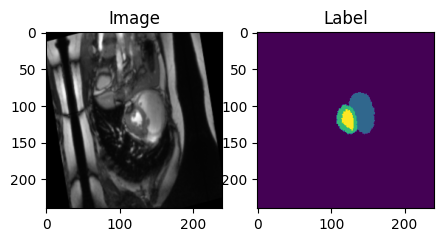

dict_keys(['image', 'label'])
image shape: torch.Size([32, 1, 240, 240, 32])
label shape: torch.Size([32, 1, 240, 240, 32])


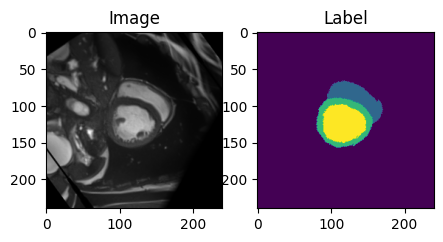

dict_keys(['image', 'label'])
image shape: torch.Size([32, 1, 240, 240, 32])
label shape: torch.Size([32, 1, 240, 240, 32])


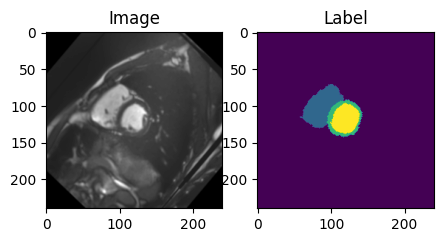

dict_keys(['image', 'label'])
image shape: torch.Size([32, 1, 240, 240, 32])
label shape: torch.Size([32, 1, 240, 240, 32])


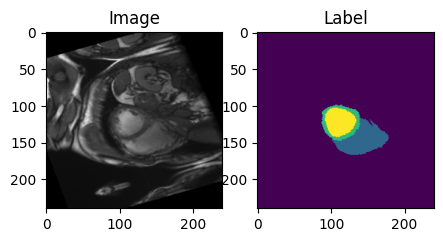

In [13]:
###
# Plot some sample images and labels
###

print(f"Train loader size: {len(train_loader)}")
plot_images(train_loader, 4)

In [14]:
###
# Validate image shapes.
# This was useful during transform pipeline development
###

for i in range(10):
    l = train_ds[i]["label"]
    s = train_ds[i]["image"].shape
    u = np.unique(l.numpy())
    if list(s) != [1, 240, 240, 32]:
        print(f"Invalid shape: {s}")

    if list(u) != [0., 1., 2., 3.]:
        print(f"Invalid labels: {s}")


## Create Model, Loss, Optimizer

In [15]:
def chooseDevice(verbose=False):
    """
    Utility function to detect the GPU with most free memory available.
    """

    if torch.cuda.is_available():
        devices = [torch.device(i) for i in range(torch.cuda.device_count())]
        memoryAvailabilitie = [torch.cuda.mem_get_info(device)[0] for device in devices]
        MostlyAvailable = np.argmax(memoryAvailabilitie)
        if verbose:
            for i in range(torch.cuda.device_count()):
                print(f"gpu {i} has {round(memoryAvailabilitie[i]/1000000)}MiB available")
            print(f"chose device {MostlyAvailable}")
        return devices[MostlyAvailable]
    else:
        return torch.device("cpu")


def wandb_masks(mask_output, mask_gt): #needs to be adapted to multiclass
    """
    Function that generates a mask dictionary in format that W&B requires 
    """

    # Apply sigmoid to model ouput and round to nearest integer (0 or 1)
    sigmoid = torch.nn.Sigmoid()
    mask_output = sigmoid(mask_output)
    mask_output = torch.round(mask_output)

    # Transform masks to numpy arrays on CPU
    # Note: .squeeze() removes all dimensions with a size of 1 (here, it makes the tensors 2-dimensional)
    # Note: .detach() removes a tensor from the computational graph to prevent gradient computation for it
    mask_output = mask_output.squeeze().detach().cpu().numpy()
    mask_gt = mask_gt.squeeze().detach().cpu().numpy()

    # Create mask dictionary with class label and insert masks
    class_labels = {1: 'ribs'}
    masks = {
        'predictions': {'mask_data': mask_output, 'class_labels': class_labels},
        'ground truth': {'mask_data': mask_gt, 'class_labels': class_labels}
    }

    return masks


def log_to_wandb(epoch, train_loss, val_loss):#, batch_data, outputs):
    """
    Function that logs ongoing training variables to W&B
    """

    # Create list of images that have segmentation masks for model output and ground truth
    # log_imgs = [wandb.Image(img, masks=wandb_masks(mask_output, mask_gt)) for img, mask_output,
    #             mask_gt in zip(batch_data['img'], outputs, batch_data['mask'])]

    # Send epoch, losses and images to W&B
    wandb.log({'epoch': epoch, 'train_loss': train_loss, 'val_loss': val_loss})#, 'results': log_imgs})


def from_compose_to_list(transform_compose):
    """
    Transform an object monai.transforms.Compose in a list fully describing the transform.
    """
    from copy import deepcopy

    if not isinstance(transform_compose, monai.transforms.Compose):
        raise TypeError("transform_compose should be a monai.transforms.Compose object.")

    output_list = list()
    for transform in transform_compose.transforms:
        kwargs = deepcopy(vars(transform))

        # Remove attributes which are not arguments
        args = list(transform.__init__.__code__.co_varnames[1: transform.__init__.__code__.co_argcount])
        for key, obj in vars(transform).items():
            if key not in args:
                del kwargs[key]

        output_list.append({"class": transform.__class__, "kwargs": kwargs})
    return output_list


def from_list_to_compose(transform_list):
    """
    Transform a list in the corresponding monai.transforms.Compose object.
    """

    if not isinstance(transform_list, list):
        raise TypeError("transform_list should be a list.")

    pre_compose_list = list()

    for transform_dict in transform_list:
        if not isinstance(transform_dict, dict) or 'class' not in transform_dict or 'kwargs' not in transform_dict:
            raise TypeError("transform_list should only contains dicts with keys ['class', 'kwargs']")

        try:
            transform = transform_dict['class'](**transform_dict['kwargs'])
        except TypeError: # Classes have been converted to str after saving
            transform = eval(transform_dict['class'].replace("__main__.", ""))(**transform_dict['kwargs'])

        pre_compose_list.append(transform)

    return monai.transforms.Compose(pre_compose_list)


def process_loader(loader, model, post_pred, post_label, loss_func, device, plot=False, sliding_window=False, plot_count=3, roi_size=(160, 160, -1), sw_batch_size = 4):
    """
    Take in a data loader, compute the loss and dice scores, and optionally plot predicted labels
    """

    dice_scores = []
    loss_scores = []
    plots = 0

    model.eval()
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    with torch.no_grad():
        for i, data in enumerate(loader):
            inputs = data["image"].to(device)

            if sliding_window:
                data["pred"] = sliding_window_inference(inputs, roi_size, sw_batch_size, model)
            else:
                p = model(inputs)
                data["pred"] = p

            outputs = [post_pred(i) for i in decollate_batch(data)]
            outputs = [x["pred"] for x in outputs]
            # outputs = outputs[0]["pred"]

            if "label" in data:
                raw_labels = data["label"].to(device)
                labels = [post_label(i) for i in decollate_batch(raw_labels)]

                # Calculate dice metric
                dice_metric(y_pred=outputs, y=labels)
                dice = dice_metric.aggregate().item()
                dice_metric.reset()
                dice_scores.append(dice)

                # Calculate loss
                metric = loss_func(p[0].unsqueeze(0), raw_labels[0].unsqueeze(0)).item()
                loss_scores.append(metric)
            else:
                metric = None


            if plot and (plot_count < 0 or plots < plot_count):
                plots += 1

                plt.figure("Segmentation", (12, 3))
                plt.subplot(1, 3, 1)
                plt.title(f"Base Image {i}")
                plt.imshow(data["image"][0, 0, :, :, 10], cmap="gray")

                subplot = 2
                if "label" in data:
                    plt.subplot(1, 3, subplot)
                    plt.title(f"Label {i}")
                    plt.imshow(data["label"][0, 0, :, :, 10])
                    subplot += 1

                plt.subplot(1, 3, subplot)
                plt.title(f"output {i} {metric if metric is not None else ''}")
                plt.imshow(torch.argmax(outputs[0], dim=0).detach().cpu()[:, :, 10])

                plt.show()
            elif not "label" in data:
                break

    if not loss_scores:
        return None

    return {
        "avg": sum(loss_scores) / len(loss_scores),
        "max": max(loss_scores),
        "min": min(loss_scores),
        "var": np.var(loss_scores),
        "std": np.std(loss_scores),
        "dice": {
            "avg": sum(dice_scores) / len(dice_scores),
            "max": max(dice_scores),
            "min": min(dice_scores),
        }
    }


def plot_curves(data: List[Dict[str, Dict[str, List[float]]]], grid_width: int=2):
    """
    Plot loss curves.
    """
    sns.set_style('whitegrid')

    num_plots = len(data)
    grid_height = np.ceil(num_plots / grid_width).astype(int)
    fig, axes = plt.subplots(grid_height, grid_width, figsize=(10*grid_width, grid_height*5))
    axes = axes.ravel()

    for idx in range(grid_width*grid_height):
        if idx < num_plots:
            plot_data = data[idx]
            df = pd.DataFrame(plot_data['lines'], index=plot_data.get('x_values'))

            palette = sns.color_palette("husl", len(df.columns))

            line_handles = []
            for line_id, line_name in enumerate(df.columns):
                line = df[line_name]
                line_plot, = axes[idx].plot(line.index, line.values, color=palette[line_id])
                line_handles.append(line_plot)

                # Add shaded band for each line, if provided
                if 'band' in plot_data and line_name in plot_data['band']:
                    band_min, band_max = plot_data['band'][line_name]
                    axes[idx].fill_between(line.index, band_min, band_max, color=palette[line_id], alpha=0.2)

            axes[idx].set_title(plot_data['title'])
            axes[idx].set_xlabel(plot_data['x_label'])

            axes[idx].legend(line_handles, df.columns)
        else:
            fig.delaxes(axes[idx])  # remove extra subplots

    plt.tight_layout()
    plt.show()


def plot_lr(optimizer, scheduler, steps_per_epoch, num_epochs):
    """
    Plot learning rate graph
    """
    lrs = []

    for epoch in range(num_epochs):
        for step in range(steps_per_epoch):
            optimizer.step()
            scheduler.step()
            lrs.append(optimizer.param_groups[0]['lr'])

    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 7))
    sns.lineplot(data=lrs)
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.show()

Using device(s): 0, cuda:0
[0.024999999999999994]


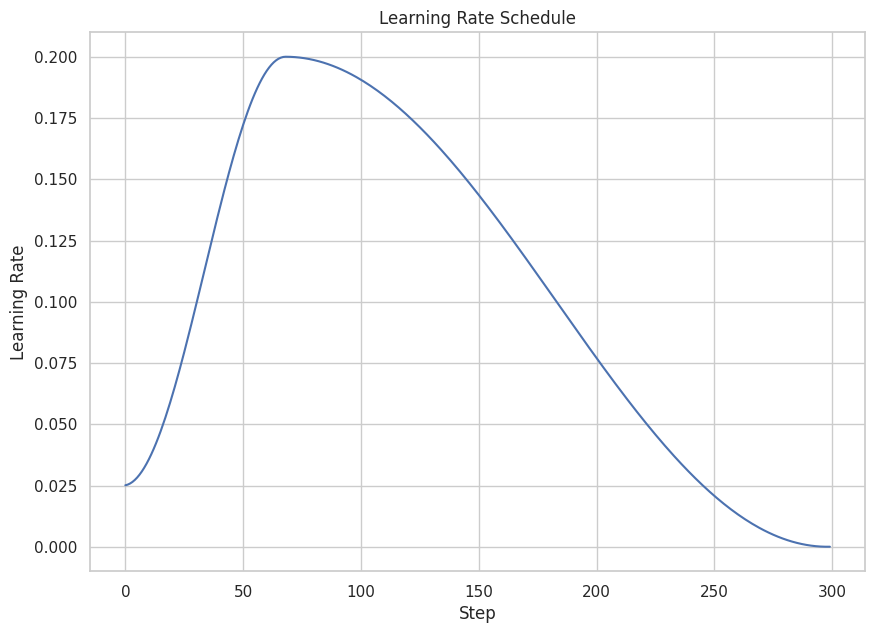

[1.1828286942748172e-05]


In [19]:
###
# Functions to initialize the model
###

# NOTE: Comment to enable reproducability
set_determinism(seed=time.time())

# Some experiments with a SwinNet, not completed
# model = SwinUNETR(
#     img_size=(256, 256, 32),
#     in_channels=1,
#     out_channels=4,
#     depths=(2, 2, 2, 2),
#     num_heads=(3, 6, 12, 24),
#     feature_size=132,
#     norm_name='batch',
#     drop_rate=dropout, 
#     attn_drop_rate=0.0, 
#     dropout_path_rate=0.0, 
#     normalize=True, 
#     use_checkpoint=False,
#     spatial_dims=3,
#     downsample='merging',
#     use_v2=False,
# )


def init_model(devices, dropout=0.2):
    device = f"cuda:{devices[0]}"
    print(f"Using device(s): {', '.join(str(x) for x in devices)}, {device}")

    model = UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=4,
        channels=(16, 32, 64, 128, 256, 512),
        strides=(2, 2, 2, 1, 2),
        num_res_units=6,
        dropout=dropout,
        norm=Norm.BATCH,
    )


    model = model.to(device)
    model_name = type(model).__name__

    if len(devices) > 1:
        print("Using multi GPU training")
        model = torch.nn.DataParallel(model, device_ids=devices)

    return model, model_name, device


def init_loss(val_loader, include_background=False, gdl_weight=1, focal_weight=1, gamma=2, one_hot=True, sigmoid=True):
    # Calculate the mean volume of each class label, and set the Focal loss weights accordingly
    mean_area = calculate_mean_area(val_loader)

    loss_function = GeneralizedDiceFocalLoss(
        include_background=include_background,
        sigmoid=sigmoid,
        to_onehot_y=one_hot,
        gamma=gamma,
        focal_weight=mean_area["loss_weights"][not include_background:].numpy(),
        lambda_gdl=gdl_weight,
        lambda_focal=focal_weight,
    )
    return loss_function


def init_optimizer(model, learning_rate, weight_decay=1e-2):
    # optimizer = torch.optim.Adam(
    #     model.parameters(),
    #     learning_rate,
    #     weight_decay=weight_decay,
    # )

    optimizer = torch.optim.SGD(
        model.parameters(),
        learning_rate,
        weight_decay=weight_decay,
    )
    return optimizer


def init_lr_scheduler(optimizer, max_lr, epochs, batch_count, last_batch=-1):
    if last_batch < 1:
        last_batch = -1

    scheduler = OneCycleLR(
        optimizer,
        max_lr=max_lr,
        epochs=epochs,
        steps_per_epoch=batch_count,
        div_factor=8,
        last_epoch=last_batch,
        pct_start=0.7/epochs,
        final_div_factor=1e4,
        three_phase=False,
        max_momentum=0.1
    )
    return scheduler


def init_scaler():
    scaler = torch.cuda.amp.GradScaler()
    return scaler


# Plot learning rate with scheduler
epochs = 3
steps_epoch = 100
model_t, model_name, device = init_model([0])
loss_function = init_loss(val_loader)
optimizer = init_optimizer(model_t, 1e-4)
scheduler = init_lr_scheduler(optimizer,
                              max_lr=0.2,
                              epochs=epochs,
                              batch_count=steps_epoch)

plot_lr(optimizer, scheduler, steps_epoch, epochs)

del model_t, optimizer, scheduler

gc.collect()
torch.cuda.empty_cache()

In [ ]:
###
# Learning rate finder test
#
# Used as exploration to determine the max learning rate
# for the 1 cycle learning rate policy
###

devices = [0, 1]
model, model_name, device = init_model(devices)
loss_function = init_loss(val_loader)
optimizer = init_optimizer(model, 1e-4)
fp16_scaler = init_scaler()

batch_size = 10
finder_ds = ACDCDataset(image_dir, label_dir, max_augmentations_per_image=5)
# finder_ds = CacheDataset(data=finder_ds, cache_rate=1.0, num_workers=110)
# finder_loader = DataLoader(finder_ds, batch_size=32, shuffle=True)
finder_loader = DataLoaderLRFinder(train_ds, batch_size=batch_size, shuffle=True)
finder_val = DataLoaderLRFinder(vds, batch_size=1)

time.sleep(1)
gc.collect()
torch.cuda.empty_cache()
time.sleep(1)

epochs = 1
desired_batch_size = 20
steps = desired_batch_size // batch_size
iterations = int(len(finder_loader) * epochs // steps)

lr_finder = LRFinder(model, optimizer, loss_function)
lr_finder.range_test(finder_loader, start_lr=1e-4, end_lr=1, num_iter=iterations, accumulation_steps=steps)
lr_finder.plot()
lr_finder.reset()
del lr_finder, finder_val, finder_loader, finder_ds

# 1.98E-03
# 4.64E-02
# 3.35E-02

In [26]:
###
# Create model - run this code to reset the model
###

best_metric = 100
metric = 0
best_metric_epoch = -1
iteration_loss_values = []
iteration_epoch_fraction = []
iteration_lr = []
metric_values = []
val_min = []
val_max = []
dice_metrics = []
dice_max = []
dice_min = []

epoch_total = 0
steps_total = 0
current_datetime = datetime.now()

devices = [0, 1]
model, model_name, device = init_model(devices, dropout=0.5)
loss_function = init_loss(val_loader, gdl_weight=1, focal_weight=1, gamma=2)
optimizer = init_optimizer(model, 1e-4)
scaler = init_scaler()


gc.collect()
# torch.cuda.empty_cache()

Using device(s): 0, 1, cuda:0
Using multi GPU training


4

In [27]:
###
# Clear GPU memory to prevent batch sizing issues
###

try:
    del scheduler
except:
    pass

gc.collect()
torch.cuda.empty_cache()

In [22]:
###
# Init WandB
###

# Convert the datetime object to a string
current_datetime_string = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
run = wandb.init(
    project='ACDC',
    name='training_'+current_datetime_string,
    config={
        'loss function': str(loss_function), 
        'lr': optimizer.param_groups[0]["lr"],
        'train_transform': from_compose_to_list(train_transforms),
        'val_transform': from_compose_to_list(val_transforms),
        'train_batch_size': train_loader.batch_size,
        'val_batch_size': val_loader.batch_size,
        'model': model_name,
    }
)
# Do not hesitate to enrich this list of settings to be able to correctly keep track of your experiments!
# For example you should add information on your model...

run_id = run.id # We remember here the run ID to be able to write the evaluation metrics

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: d-brouwer-ut (ut-team1). Use `wandb login --relogin` to force relogin


## Execute a typical PyTorch training process

Epoch 1/10:   0%|          | 0/313 [00:00<?, ?it/s]

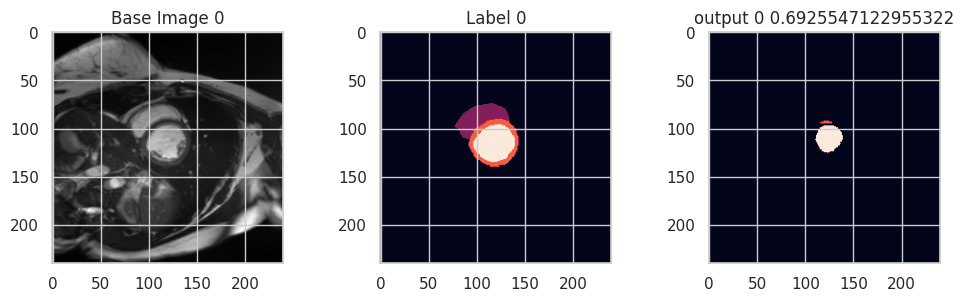

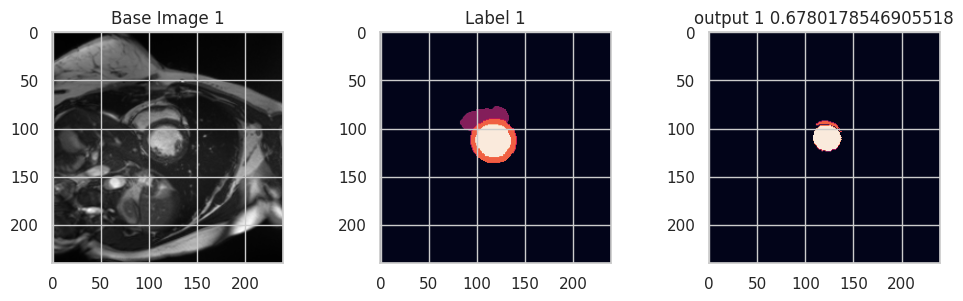

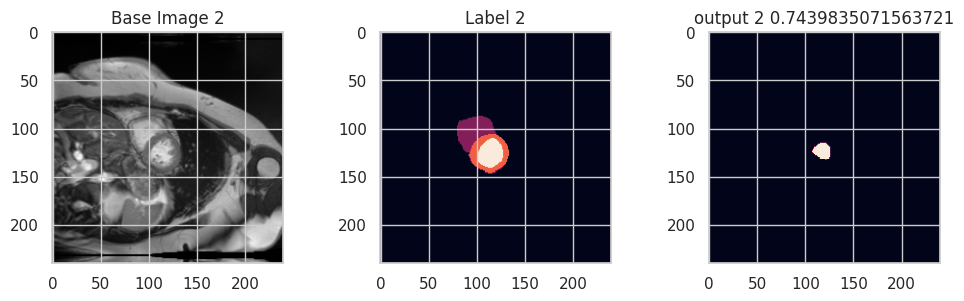

epoch 1 average loss: 0.8423


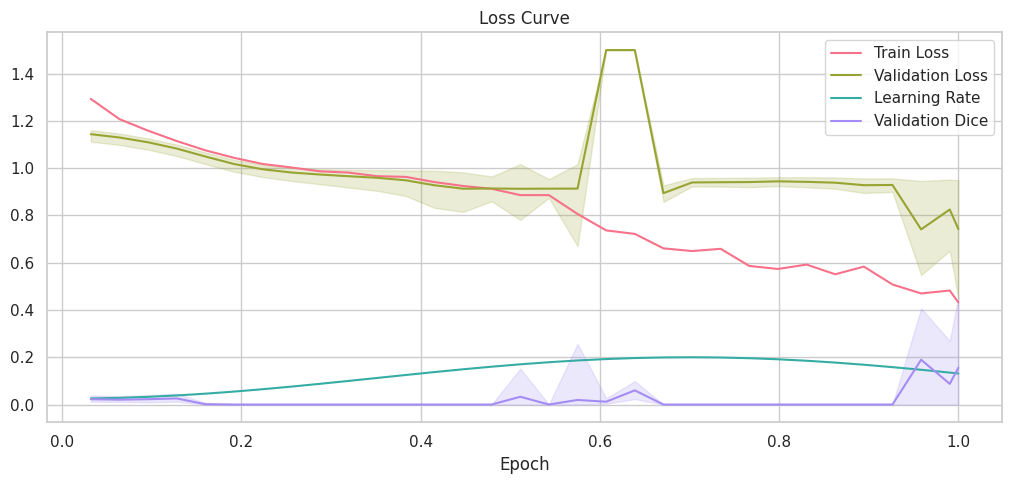

saved new best metric model
current epoch: 1 current mean dice: 0.7426
Dice Scores: {'avg': 0.7425955003499984, 'max': 0.9497153759002686, 'min': 0.4498402774333954, 'var': 0.01266350615828903, 'std': 0.11253224497133713, 'dice': {'avg': 0.15546496259979903, 'max': 0.45554637908935547, 'min': 0.0}}
best mean dice: 0.7426 at epoch: 1


Epoch 2/10:   0%|          | 0/313 [00:00<?, ?it/s]

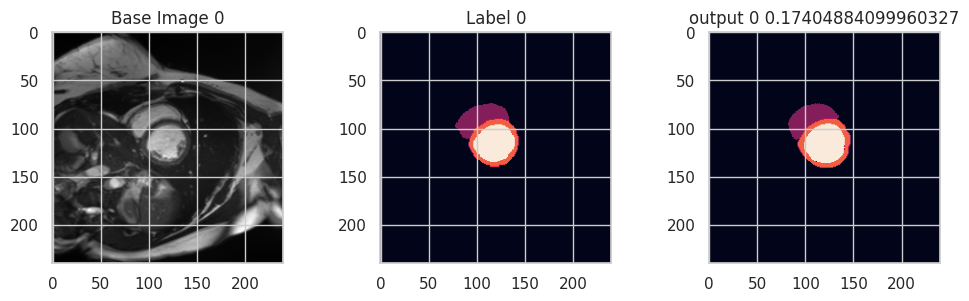

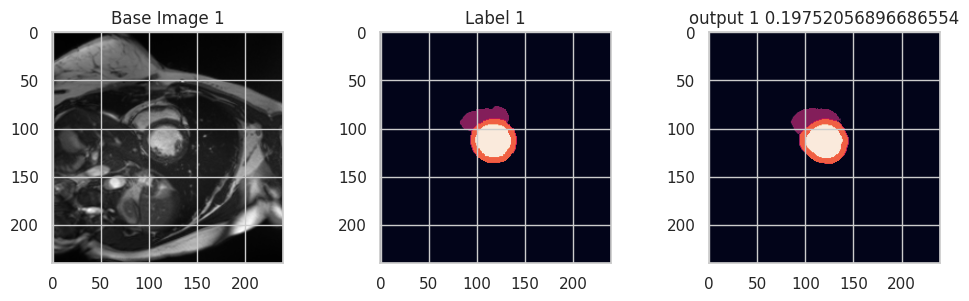

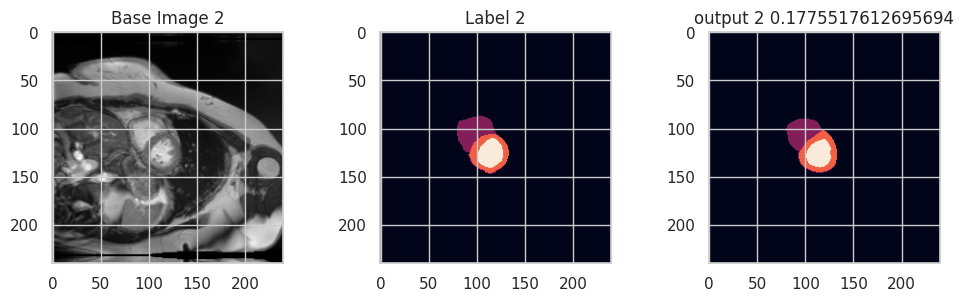

epoch 2 average loss: 0.2657


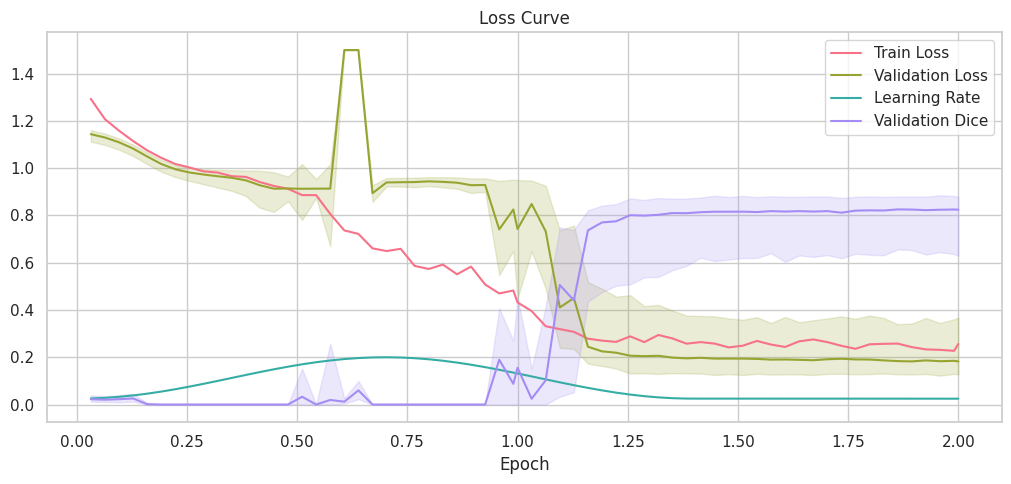

saved new best metric model
current epoch: 2 current mean dice: 0.1824
Dice Scores: {'avg': 0.18237623631954192, 'max': 0.36742526292800903, 'min': 0.1279781609773636, 'var': 0.002216239449117596, 'std': 0.04707695241960333, 'dice': {'avg': 0.8244451761245728, 'max': 0.8793999552726746, 'min': 0.6294966340065002}}
best mean dice: 0.1824 at epoch: 2


Epoch 3/10:   0%|          | 0/313 [00:00<?, ?it/s]

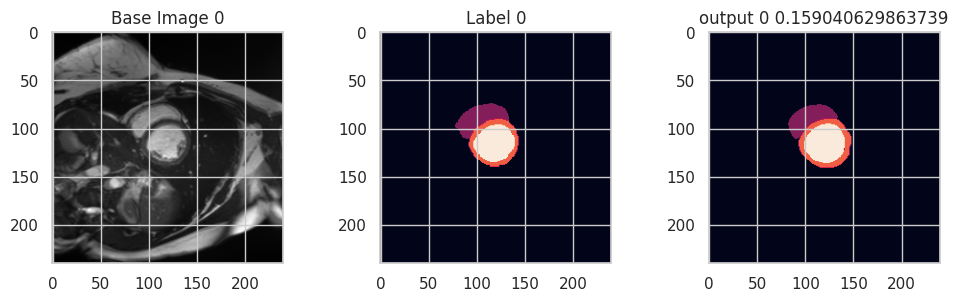

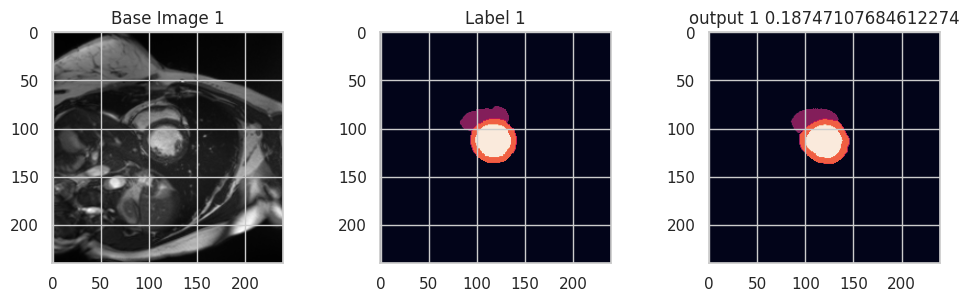

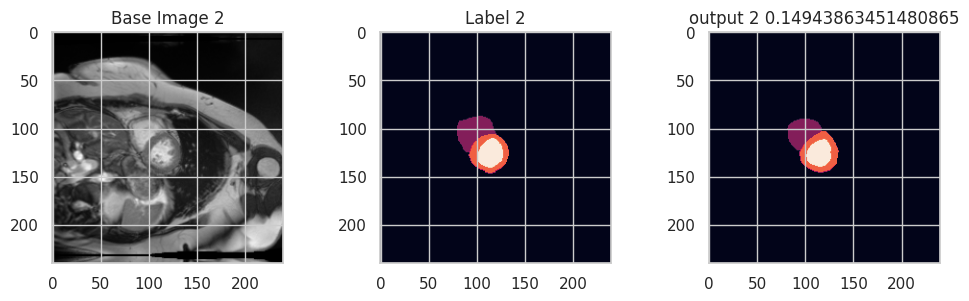

epoch 3 average loss: 0.2318


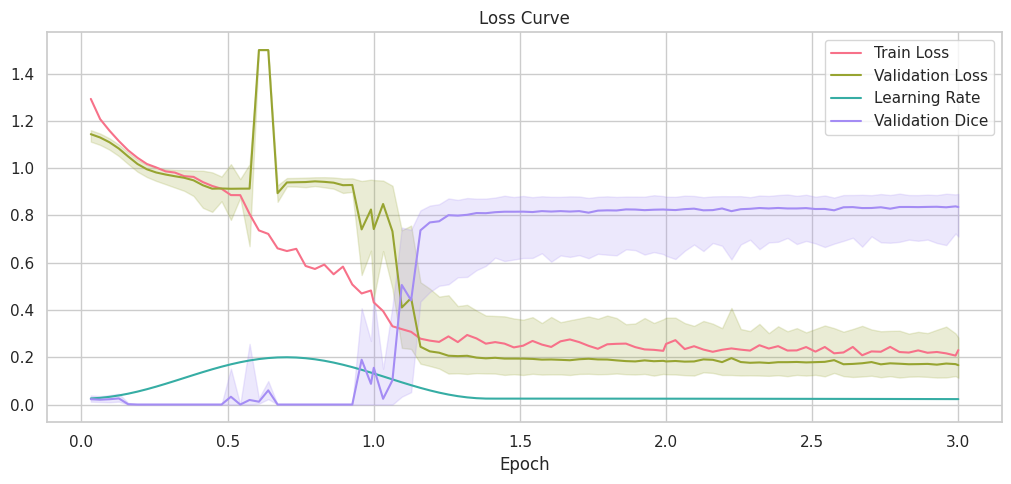

saved new best metric model
current epoch: 3 current mean dice: 0.1665
Dice Scores: {'avg': 0.16646783515810967, 'max': 0.283139705657959, 'min': 0.11324166506528854, 'var': 0.0015411914618595189, 'std': 0.03925801143536844, 'dice': {'avg': 0.8358321487903595, 'max': 0.8909821510314941, 'min': 0.710728645324707}}
best mean dice: 0.1665 at epoch: 3


Epoch 4/10:   0%|          | 0/313 [00:00<?, ?it/s]

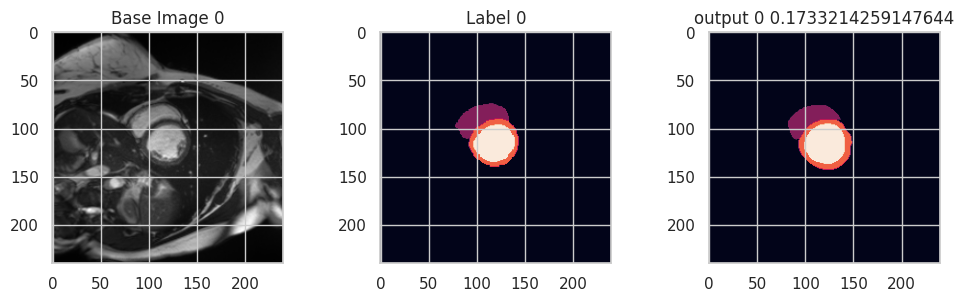

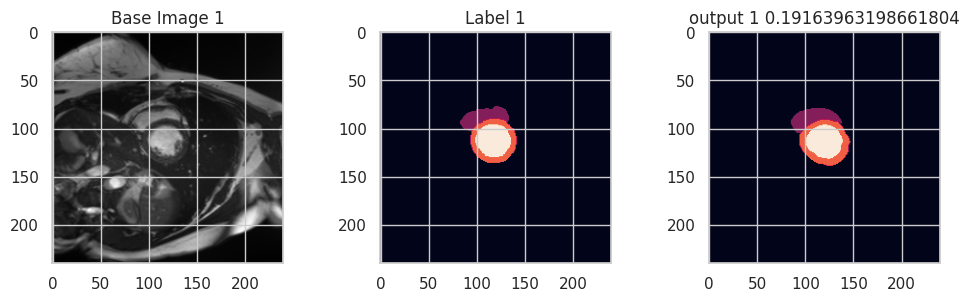

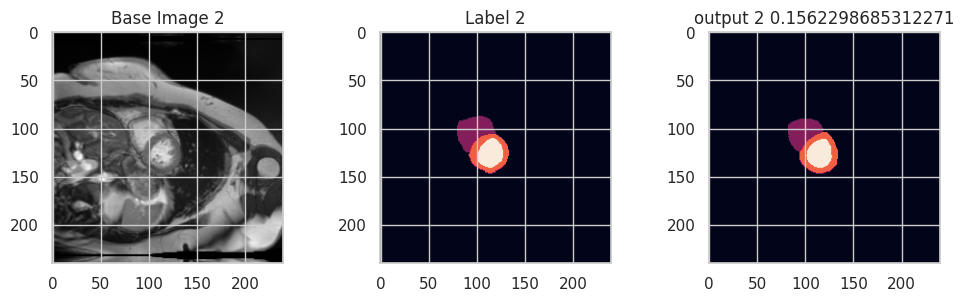

epoch 4 average loss: 0.2136


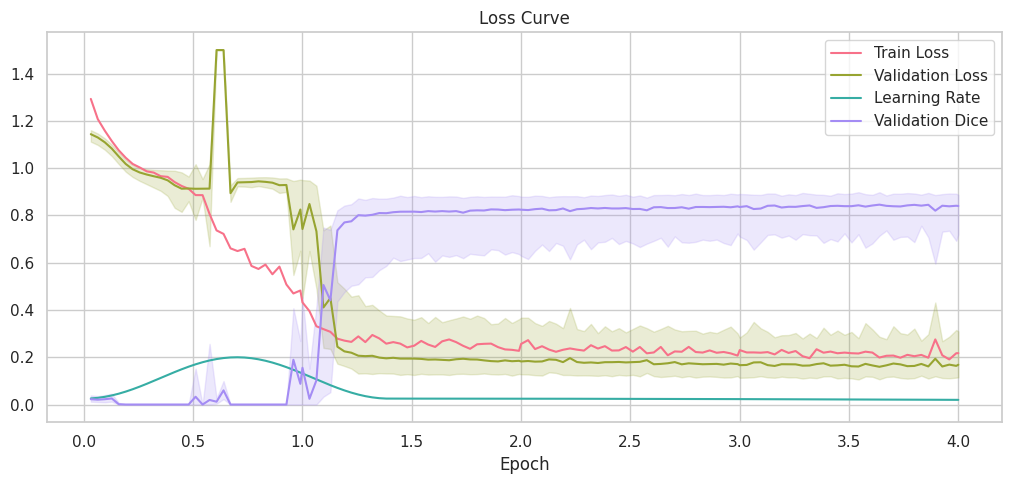

current epoch: 4 current mean dice: 0.1684
Dice Scores: {'avg': 0.16839125141501426, 'max': 0.3095228374004364, 'min': 0.11494342982769012, 'var': 0.0015873754496397688, 'std': 0.0398418805986837, 'dice': {'avg': 0.8401891303062439, 'max': 0.8871976733207703, 'min': 0.7202722430229187}}
best mean dice: 0.1665 at epoch: 3


Epoch 5/10:   0%|          | 0/313 [00:00<?, ?it/s]

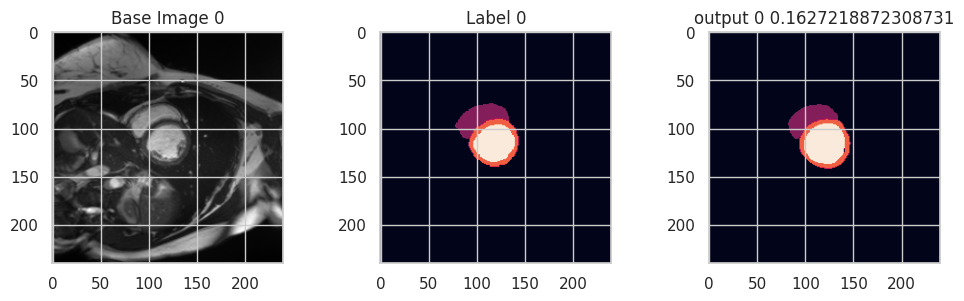

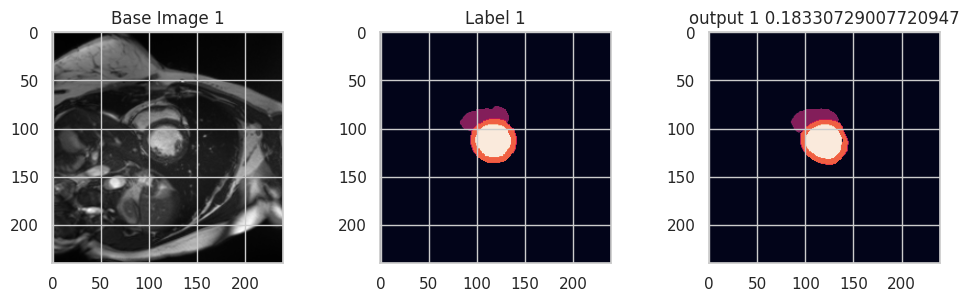

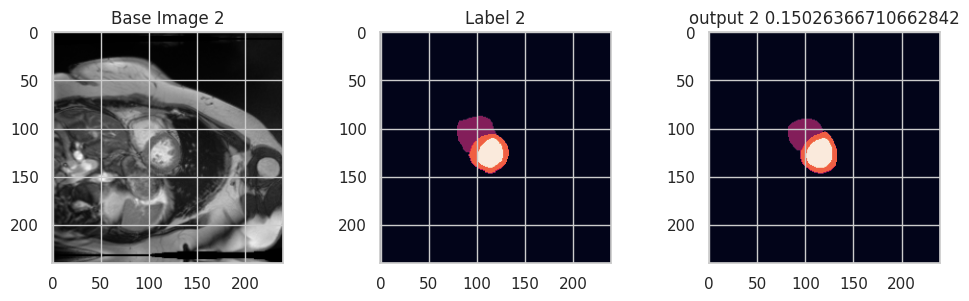

epoch 5 average loss: 0.2014


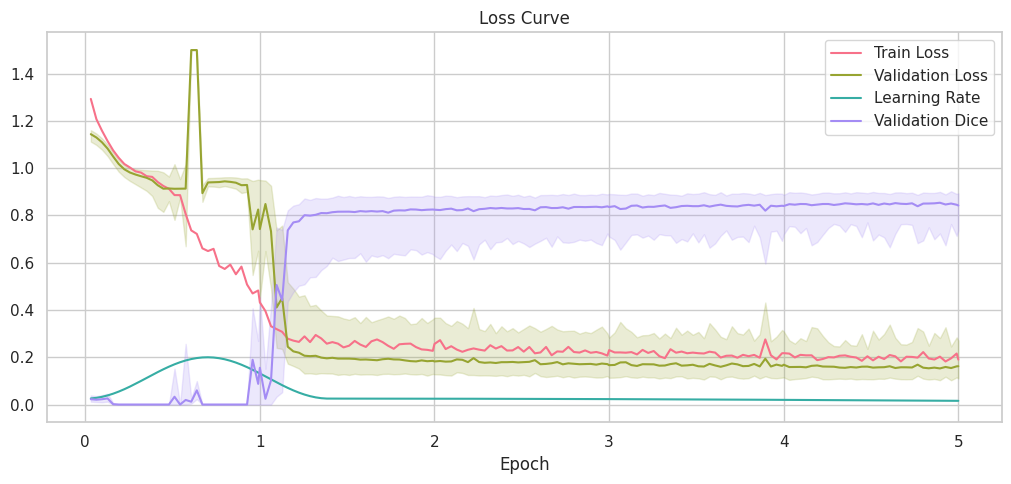

saved new best metric model
current epoch: 5 current mean dice: 0.1621
Dice Scores: {'avg': 0.16207366064190865, 'max': 0.27035441994667053, 'min': 0.11030662059783936, 'var': 0.0016396517379171143, 'std': 0.04049261337475163, 'dice': {'avg': 0.8422598421573639, 'max': 0.8936856389045715, 'min': 0.7368621826171875}}
best mean dice: 0.1621 at epoch: 5


Epoch 6/10:   0%|          | 0/313 [00:00<?, ?it/s]

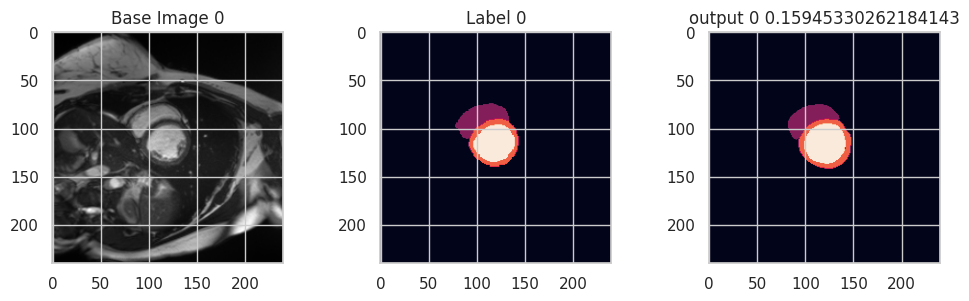

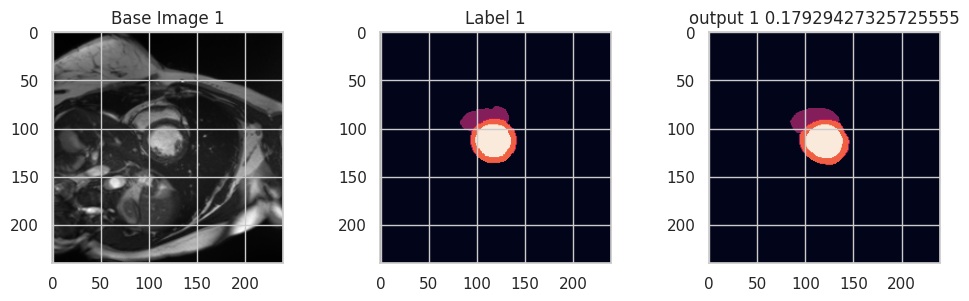

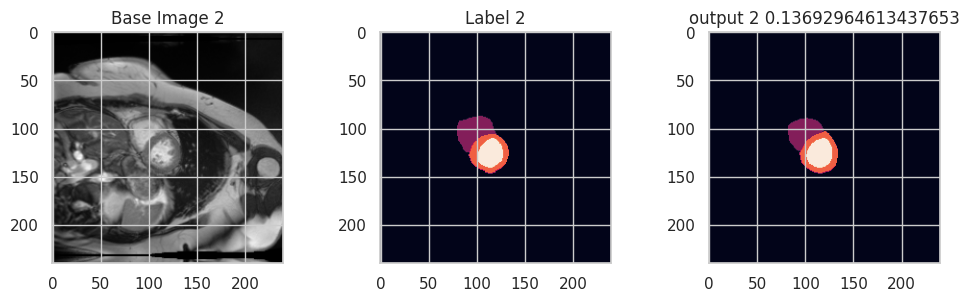

epoch 6 average loss: 0.1920


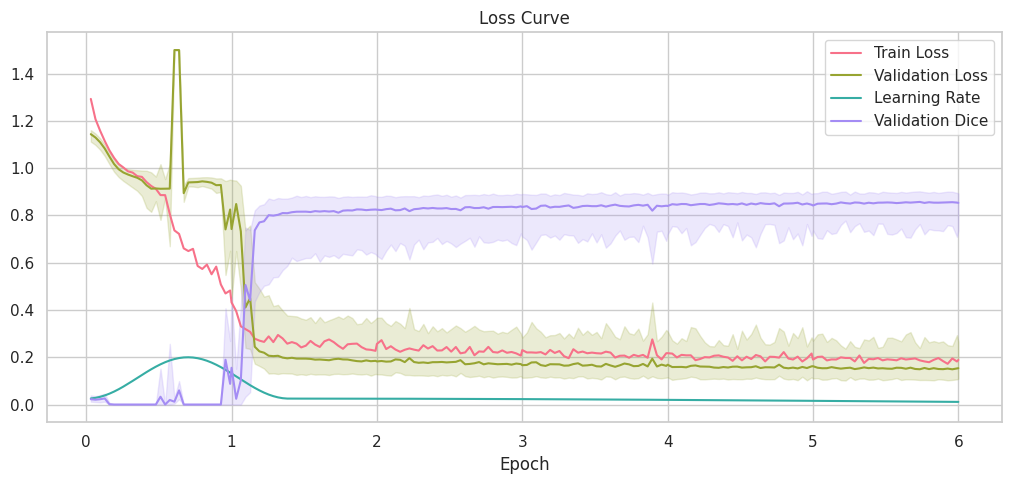

saved new best metric model
current epoch: 6 current mean dice: 0.1538
Dice Scores: {'avg': 0.15375547125935554, 'max': 0.2654314339160919, 'min': 0.10934659838676453, 'var': 0.0011599590366044822, 'std': 0.03405817136319098, 'dice': {'avg': 0.8533581733703614, 'max': 0.8932276368141174, 'min': 0.7361843585968018}}
best mean dice: 0.1538 at epoch: 6


Epoch 7/10:   0%|          | 0/313 [00:00<?, ?it/s]

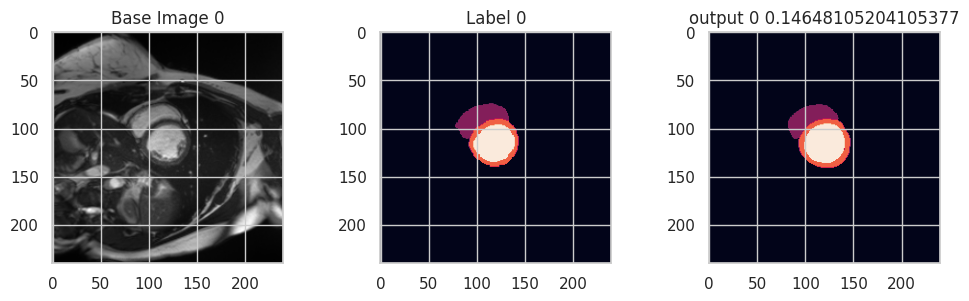

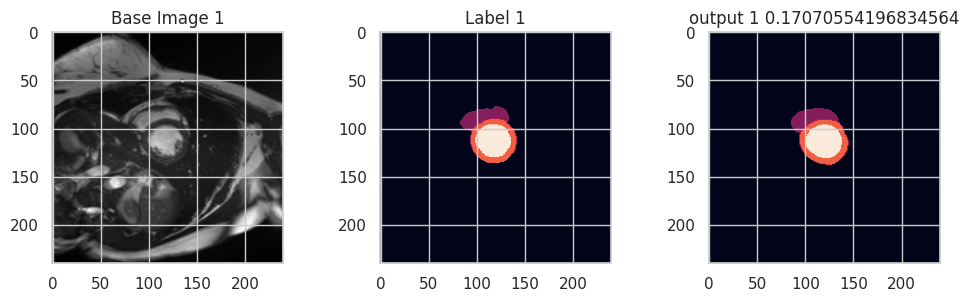

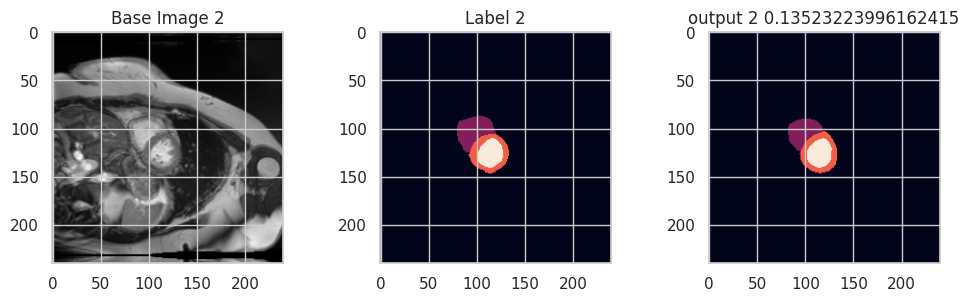

epoch 7 average loss: 0.1847


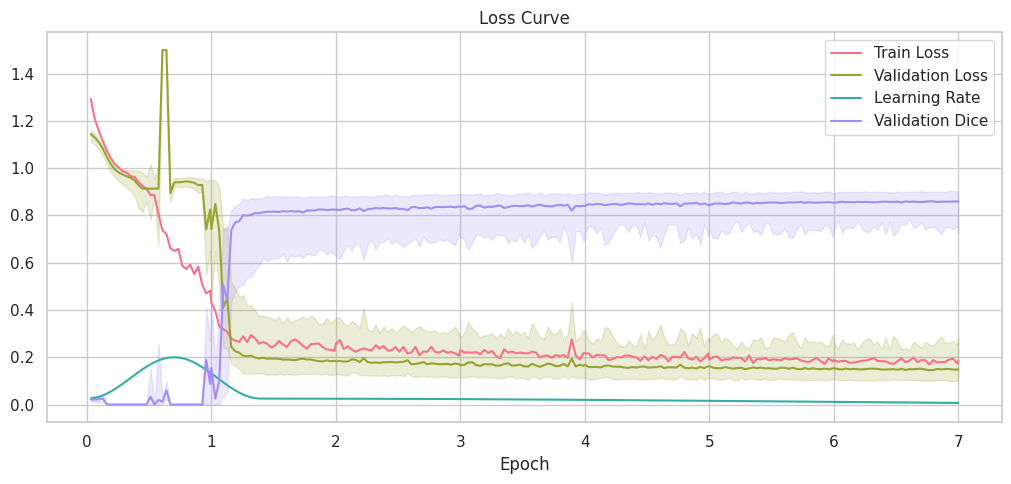

saved new best metric model
current epoch: 7 current mean dice: 0.1484
Dice Scores: {'avg': 0.14840640604496003, 'max': 0.28137457370758057, 'min': 0.10596174746751785, 'var': 0.0011029706822327661, 'std': 0.03321100242739996, 'dice': {'avg': 0.8576797461509704, 'max': 0.8977222442626953, 'min': 0.7211227416992188}}
best mean dice: 0.1484 at epoch: 7


Epoch 8/10:   0%|          | 0/313 [00:00<?, ?it/s]

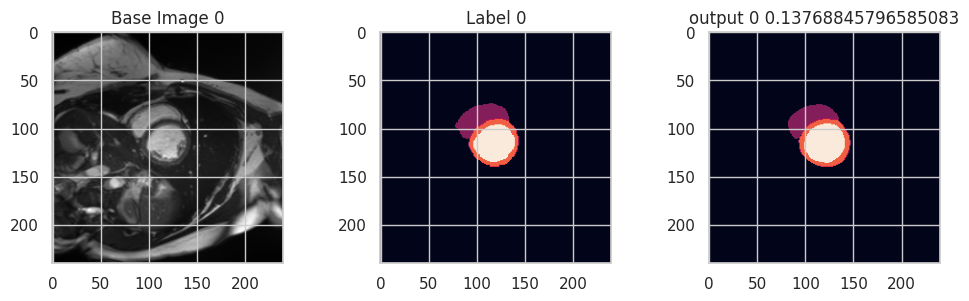

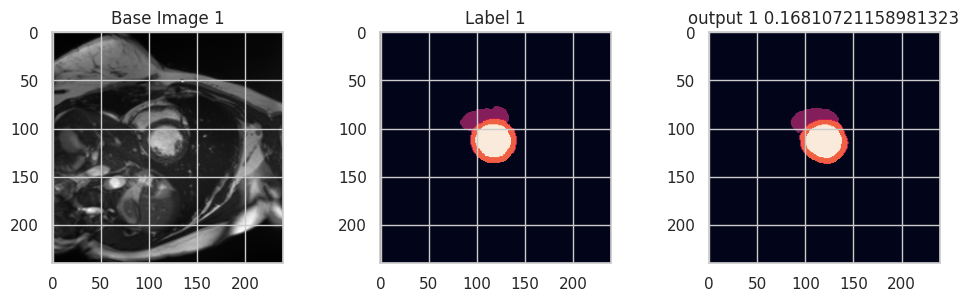

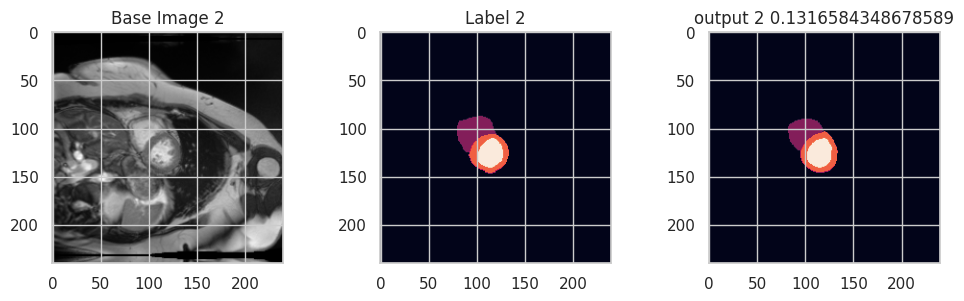

epoch 8 average loss: 0.1803


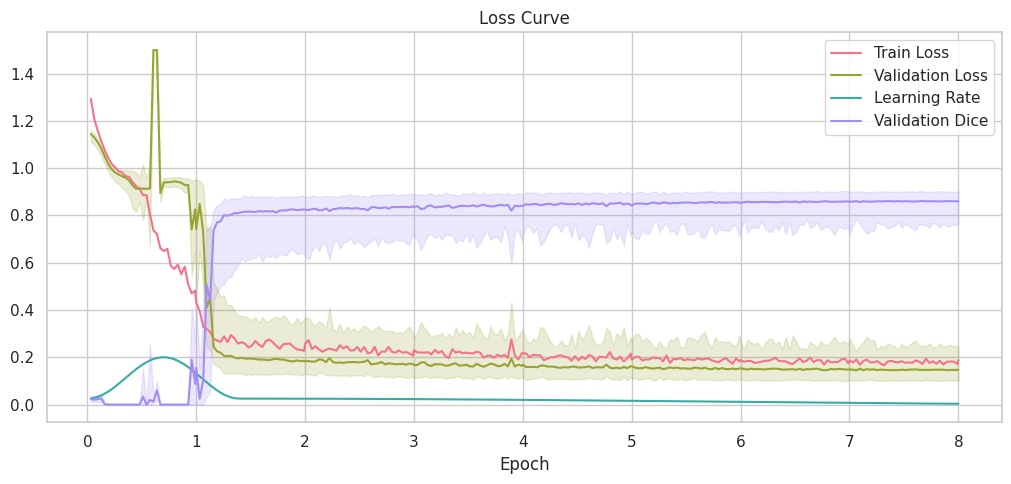

saved new best metric model
current epoch: 8 current mean dice: 0.1465
Dice Scores: {'avg': 0.14651497840881347, 'max': 0.24178749322891235, 'min': 0.10267123579978943, 'var': 0.0009747763665446278, 'std': 0.0312214087853932, 'dice': {'avg': 0.859817076921463, 'max': 0.8997955918312073, 'min': 0.7647190093994141}}
best mean dice: 0.1465 at epoch: 8


Epoch 9/10:   0%|          | 0/313 [00:00<?, ?it/s]

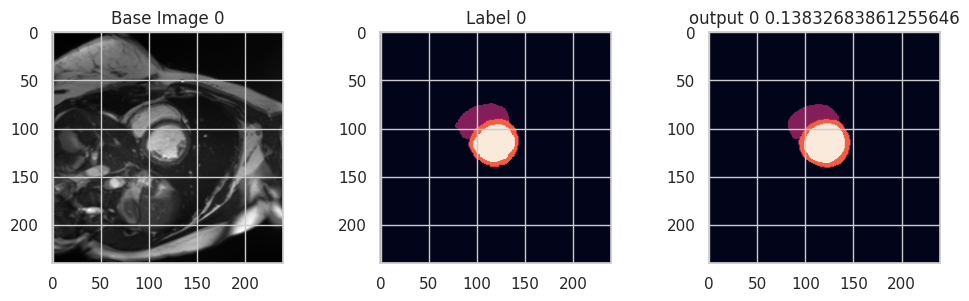

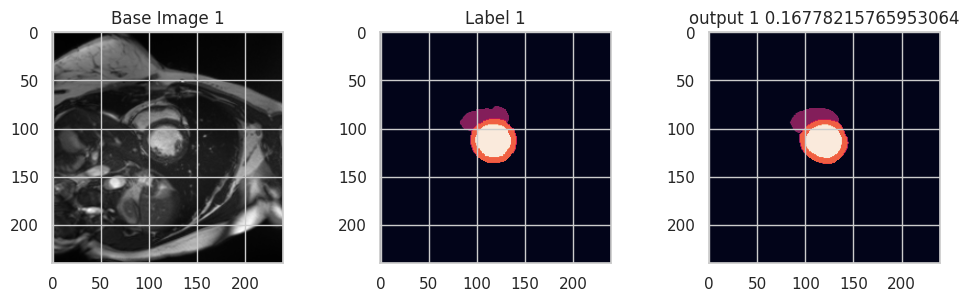

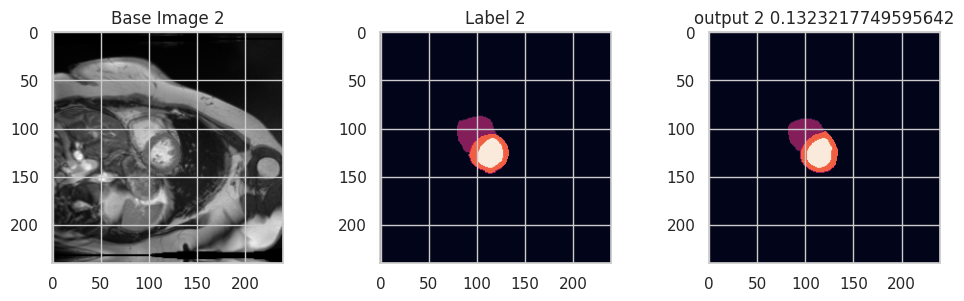

epoch 9 average loss: 0.1783


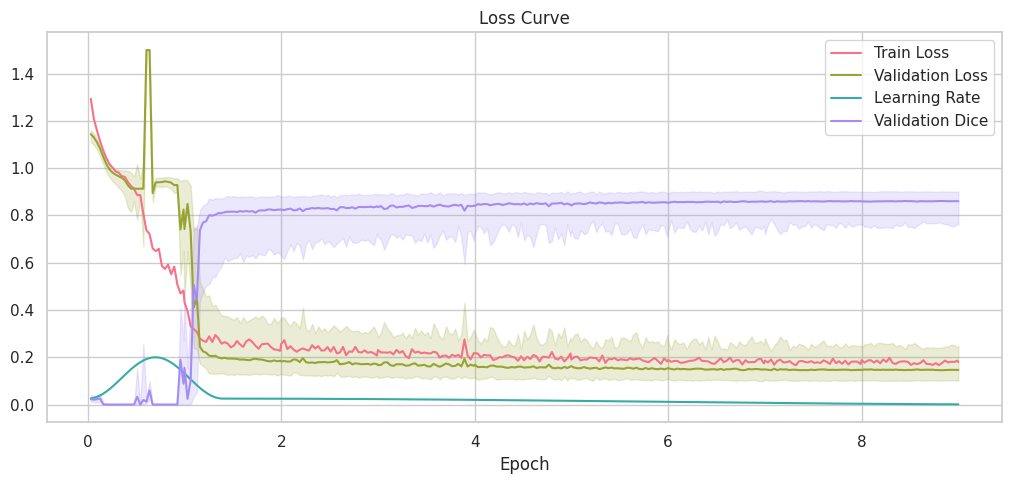

saved new best metric model
current epoch: 9 current mean dice: 0.1464
Dice Scores: {'avg': 0.14644936561584473, 'max': 0.24741938710212708, 'min': 0.10160810500383377, 'var': 0.0009891247384357974, 'std': 0.031450353550251185, 'dice': {'avg': 0.8604912745952606, 'max': 0.9013710618019104, 'min': 0.7604737281799316}}
best mean dice: 0.1464 at epoch: 9


Epoch 10/10:   0%|          | 0/313 [00:00<?, ?it/s]

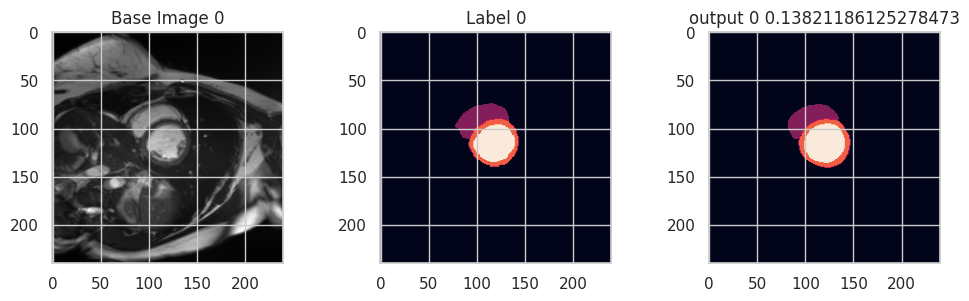

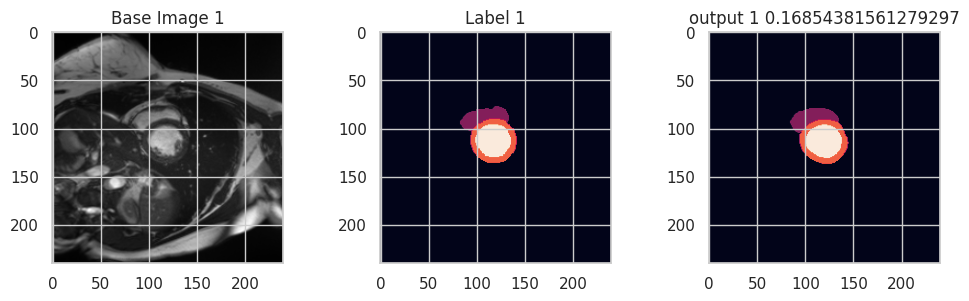

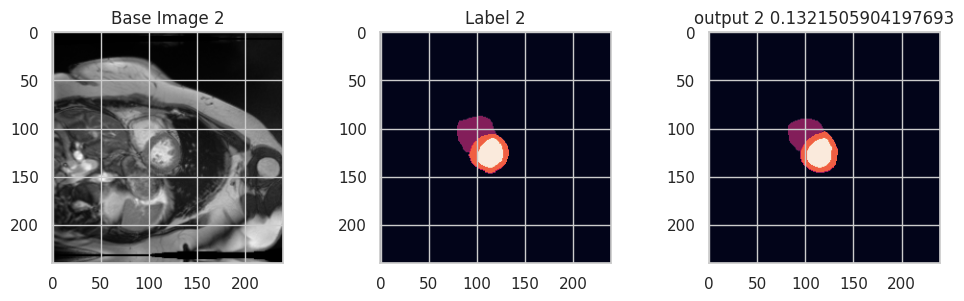

epoch 10 average loss: 0.1776


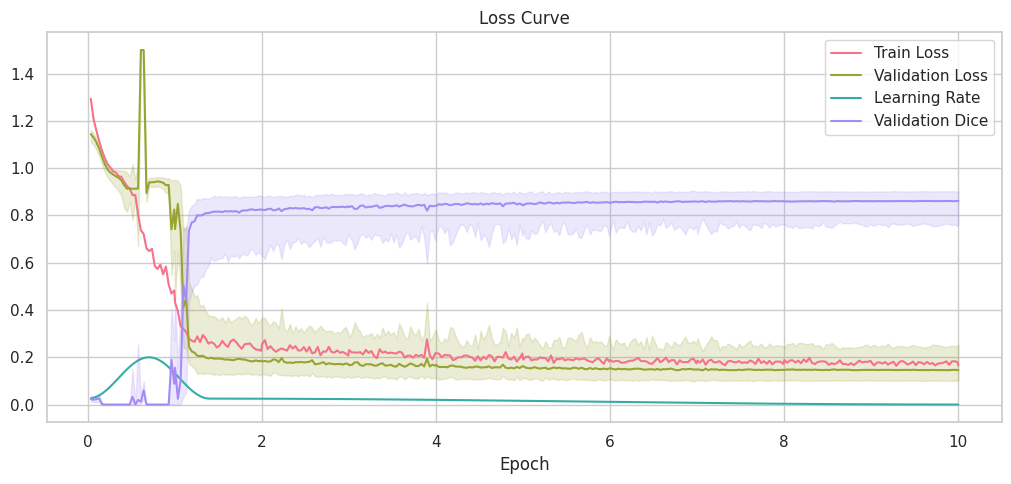

saved new best metric model
current epoch: 10 current mean dice: 0.1455
Dice Scores: {'avg': 0.14551823794841767, 'max': 0.24803583323955536, 'min': 0.10094881802797318, 'var': 0.0009569523253628499, 'std': 0.03093464603584224, 'dice': {'avg': 0.8613626205921173, 'max': 0.9023000597953796, 'min': 0.7601878046989441}}
best mean dice: 0.1455 at epoch: 10


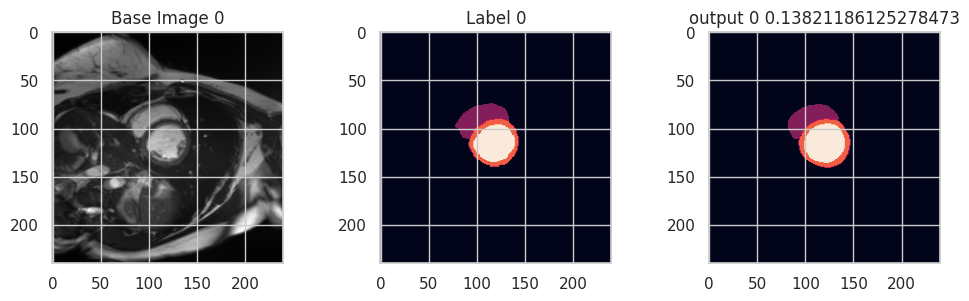

Final Score: {'avg': 0.14783161334693432, 'max': 0.34037816524505615, 'min': 0.0794493556022644, 'var': 0.0016683688736849687, 'std': 0.04084567141919654, 'dice': {'avg': 0.8593985950946808, 'max': 0.9221073985099792, 'min': 0.668968141078949}}


In [28]:
###
# Train the model
#
# NOTE: You can run this cell multiple times to add extra training epochs to improve performance
###

gc.collect()
torch.cuda.empty_cache()

max_epochs = 10
val_interval = 1
epoch_start = epoch_total


train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
scheduler = init_lr_scheduler(optimizer,
                              max_lr=0.2,  # 5e-2
                              epochs=max_epochs,
                              batch_count=len(train_loader),
                              last_batch=steps_total)


def cut_off(val, cutoff=1.5):
    return val if val < cutoff else cutoff


def add_scores(model, plot=False):
    """
    Add loss and metric to list so that we can graph them
    """

    dice_score = process_loader(vloader, model, post_pred, post_label, loss_function, device, plot=plot, plot_count=3, sliding_window=False)
    metric = cut_off(dice_score["avg"])
    metric = metric if metric < 1.5 else 1.5

    metric_values.append(metric)
    val_min.append(cut_off(dice_score["min"]))
    val_max.append(cut_off(dice_score["max"]))
    dice_metrics.append(cut_off(dice_score["dice"]["avg"]))
    dice_max.append(cut_off(dice_score["dice"]["max"]))
    dice_min.append(cut_off(dice_score["dice"]["min"]))

    return metric, dice_score


for epoch in range(epoch_start, epoch_start + max_epochs):
    epoch_loss = 0
    step = 0

    l = tqdm(train_loader, f"Epoch {epoch+1}/{epoch_start + max_epochs}")

    ## Perform training run and backward pass
    for batch_data in l:
        model.train()
        step += 1

        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        optimizer.zero_grad()

        with torch.cuda.amp.autocast(dtype=torch.float16):
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        # loss.backward()
        # optimizer.step()

        # mixed precision training
        # backward + optimizer step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        del inputs
        del labels
        del outputs
        gc.collect()

        epoch_loss += float(loss.item())
        last_lr = scheduler.get_last_lr()[0]
        # print(type(scheduler.get_last_lr()))
        # Step 1Cycle scheduler
        try:
            scheduler.step()
        except:
            pass

        steps_total += 1

        # Log loss every 10 iterations
        if step % 10 == 0:
            iteration_loss_values.append(loss.item())
            epoch_fraction = epoch + step / len(train_loader)
            iteration_epoch_fraction.append(epoch_fraction)
            iteration_lr.append(last_lr)

            metric, dice_score = add_scores(model)

        l.set_postfix({
            "loss": f"{loss.item():.3f}",
            "v_loss": f"{metric:.3f}",
            "lr": f"{last_lr:.7f}",
        })

    iteration_loss_values.append(loss.item())
    iteration_lr.append(last_lr)
    iteration_epoch_fraction.append(epoch+1)

    metric, dice_score = add_scores(model, plot=True)

    epoch_loss /= step
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # Step the learning rate scheduler
    # scheduler.step()

    epoch_total += 1

    # Perform validation
    if (epoch + 1) % val_interval == 0:
        # Predict labels on entire validation set and comput dice scores.

        plot_curves([
            {
                'title': 'Loss Curve',
                'x_label': 'Epoch',
                'x_values': iteration_epoch_fraction,
                'lines': {
                    'Train Loss': iteration_loss_values,
                    'Validation Loss': metric_values,
                    'Learning Rate': iteration_lr,
                    'Validation Dice': dice_metrics,
                },
                'band': {
                    'Validation Loss': (val_min, val_max),
                    'Validation Dice': (dice_min, dice_max)
                }
            }
        ])

        if metric < best_metric:
            best_metric = metric
            best_metric_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(os.getcwd(), f"trainedModels", current_datetime_string+f"__best_metric_model-{epoch}-{metric}.pth"))
            print("saved new best metric model")
        print(
            f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            f"\nDice Scores: {dice_score}"
            f"\nbest mean dice: {best_metric:.4f} "
            f"at epoch: {best_metric_epoch}"
        )

        log_to_wandb(epoch, epoch_loss, metric_values[-1]) #, val_data_wndb, val_results_wndb)

dice_score = process_loader(val_loader, model, post_pred, post_label, loss_function, device, plot=True, plot_count=1, sliding_window=False)
print(f"Final Score: {dice_score}")


In [22]:
print(torch.cuda.memory_summary(device="cuda:0", abbreviated=False))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  677536 KB |   17857 MB |   47653 GB |   47652 GB |
|       from large pool |  664808 KB |   17835 MB |   47582 GB |   47582 GB |
|       from small pool |   12728 KB |      27 MB |      70 GB |      70 GB |
|---------------------------------------------------------------------------|
| Active memory         |  677536 KB |   17857 MB |   47653 GB |   47652 GB |
|       from large pool |  664808 KB |   17835 MB |   47582 GB |

In [209]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.1770 at epoch: 5


## Plot the loss and metric

In [ ]:
###
# Manually plot the graph if needed
###

plot_curves([
    {
        'title': 'Loss Curve',
        'x_label': 'Epoch',
        'x_values': iteration_epoch_fraction,
        'lines': {
            'Train Loss': iteration_loss_values,
            'Validation Loss': metric_values,
            'Learning Rate': iteration_lr,
            'Validation Dice': dice_metrics,
        },
        'band': {
            'Validation Loss': (val_min, val_max),
            'Validation Dice': (dice_min, dice_max)
        }
    }
])

In [210]:
###
# Save model manually if needed
###

# torch.save(model.state_dict(), os.path.join(os.getcwd(), f"trainedModels", current_datetime_string+f"__best_metric_model-{epoch}-{metric}.pth"))

In [ ]:
###
# Load a pre-selected winner model
###

# modelpath = sorted(glob.glob(os.path.join(base_dir,'winnerModels',"**")))[-1]
# model.load_state_dict(torch.load(modelpath))

# print(f"Loaded best model: {modelpath}")

In [57]:
###
# Load last saved training model
###

modelpath = sorted(glob.glob(os.path.join(os.getcwd(),'trainedModels',"**")))[-1]
model.load_state_dict(torch.load(modelpath))

# print(f"Loaded best model: {modelpath}")

<All keys matched successfully>

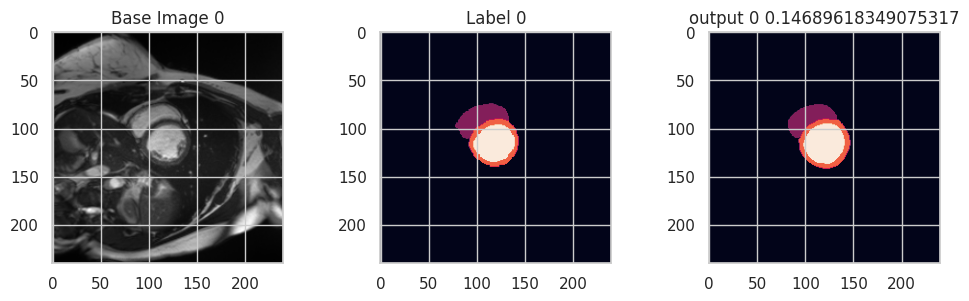

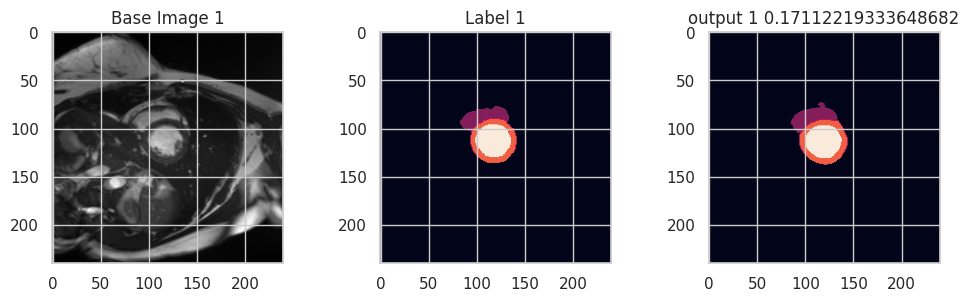

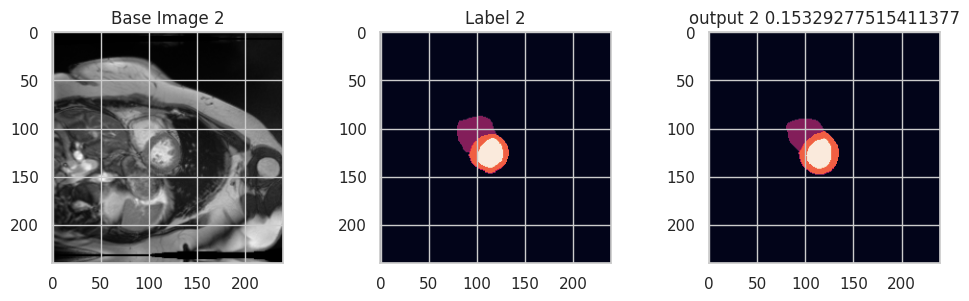

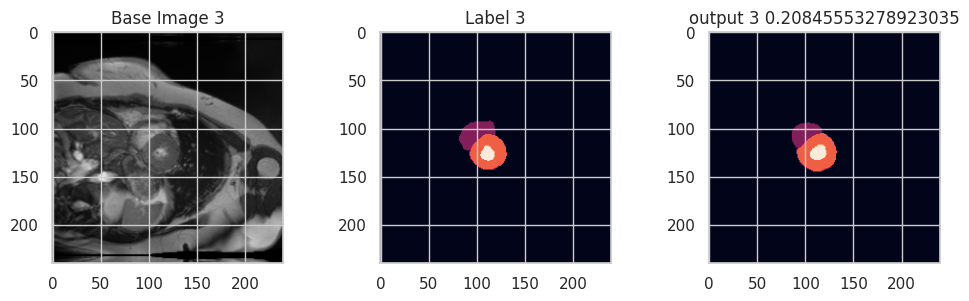

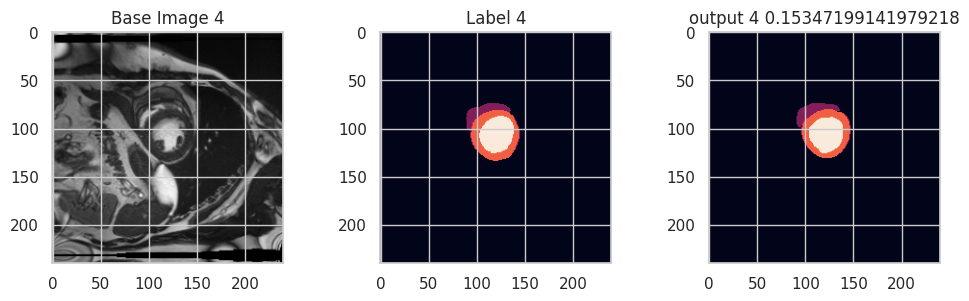

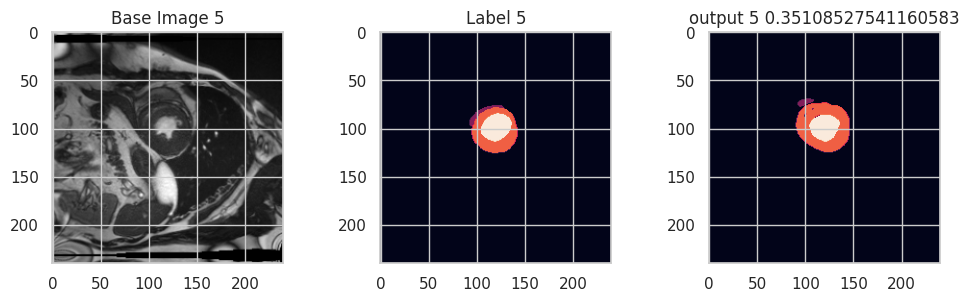

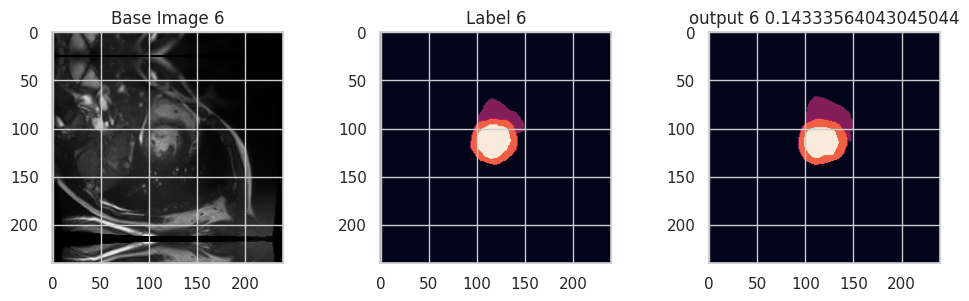

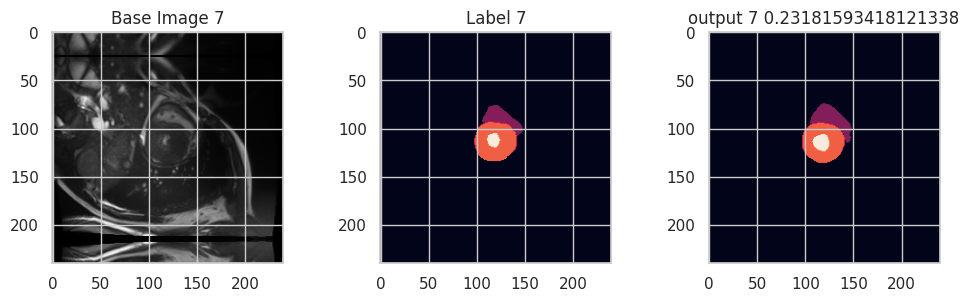

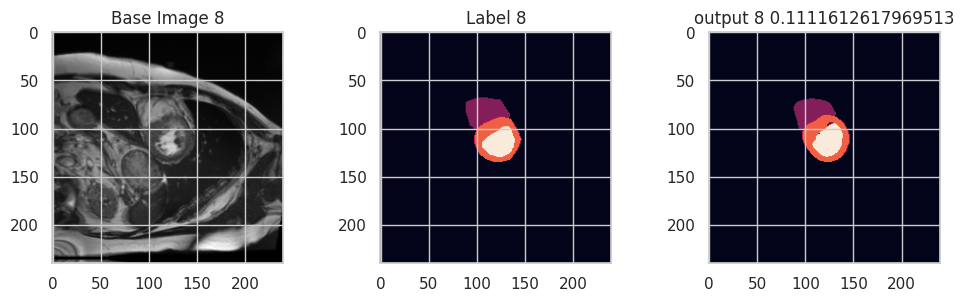

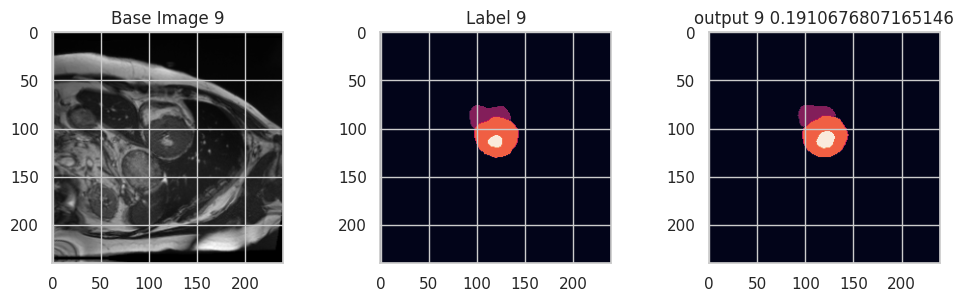

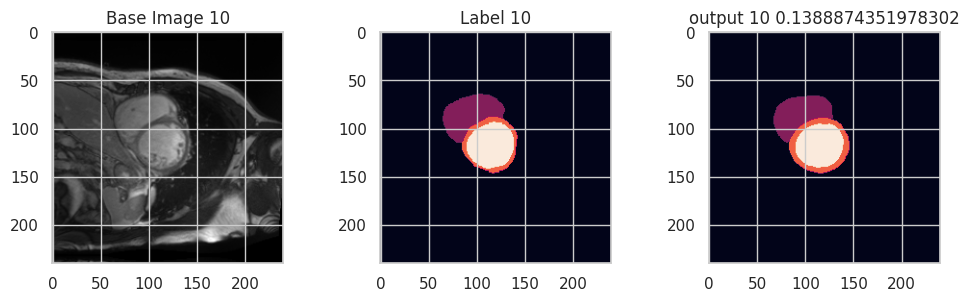

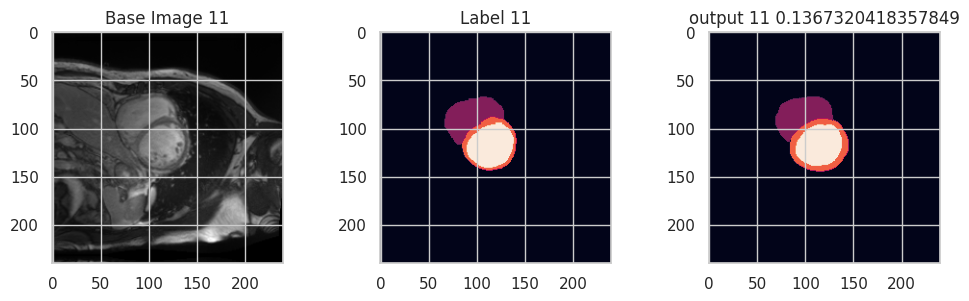

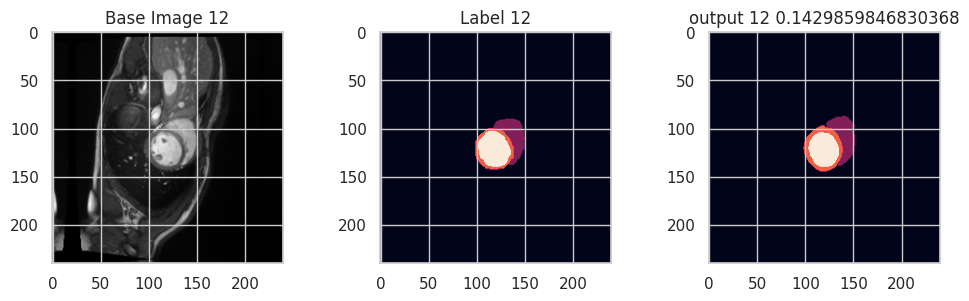

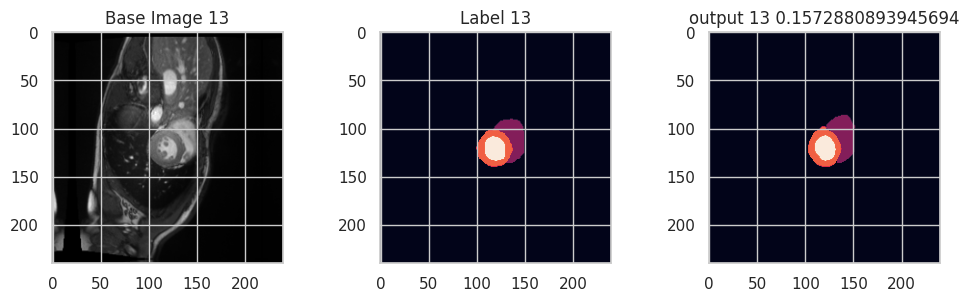

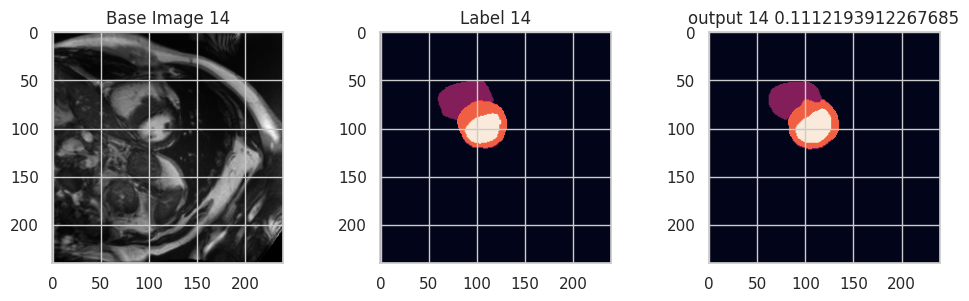

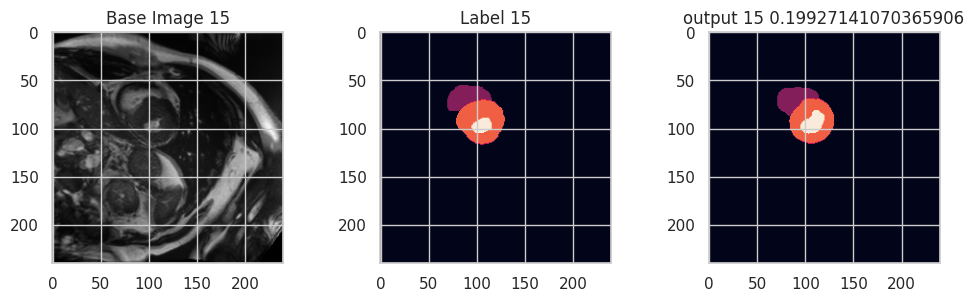

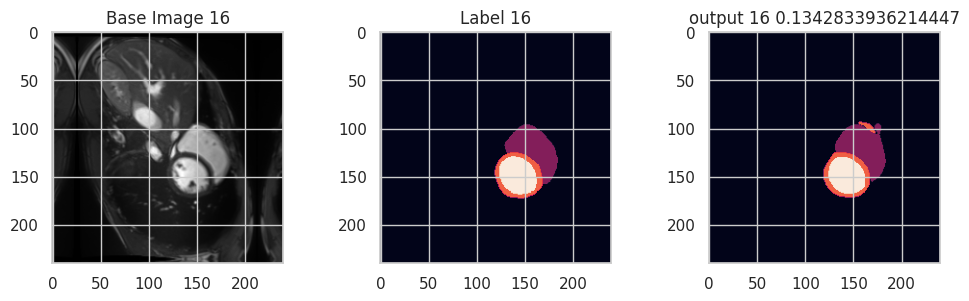

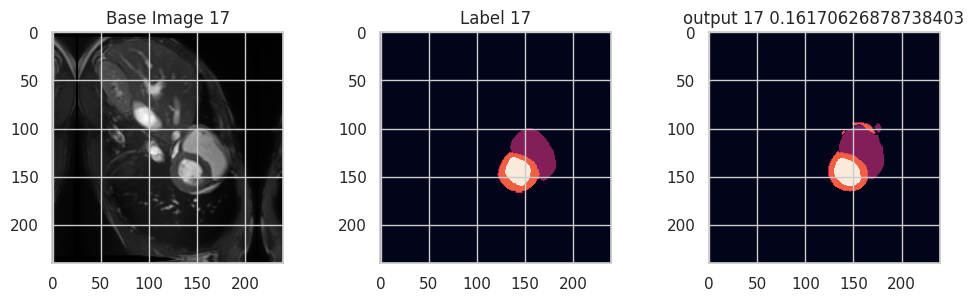

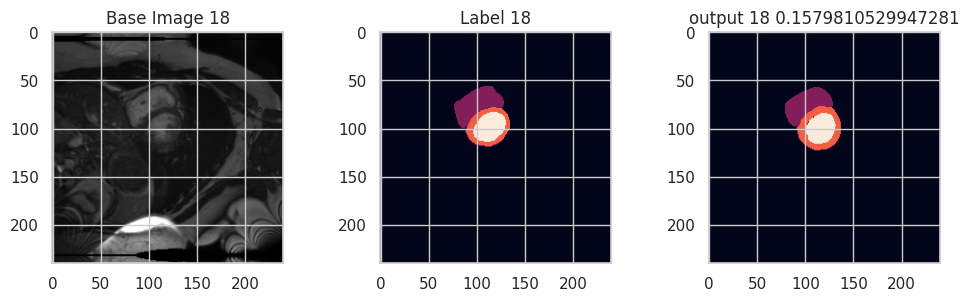

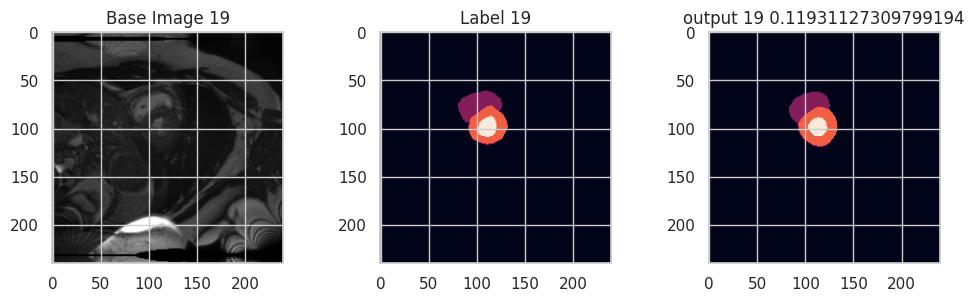

Dice score for the validation set is:
{'avg': 0.15731978453695775,
 'dice': {'avg': 0.8494899153709412,
          'max': 0.9102247357368469,
          'min': 0.6465511322021484},
 'max': 0.35108527541160583,
 'min': 0.09406158328056335,
 'std': 0.048058549486899305,
 'var': 0.0023096241787847497}


In [174]:
###
# Perform validation on the entire validation set
###

post_pred = Compose(
    [
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", argmax=True, to_onehot=4),
        KeepLargestConnectedComponent(keys="pred", applied_labels=None, independent=False, max_distance=3)
    ]
)

post_label = Compose(
    [
        AsDiscrete(to_onehot=4),
    ]
)

gc.collect()
torch.cuda.empty_cache()

# loss_function = init_loss(val_loader, gdl_weight=1, focal_weight=1, gamma=2, one_hot=True, sigmoid=True)

dice_score = process_loader(val_loader, model, post_pred, post_label, loss_function, device, plot=True, sliding_window=False, plot_count=20)

print("Dice score for the validation set is:")
pprint(dice_score)


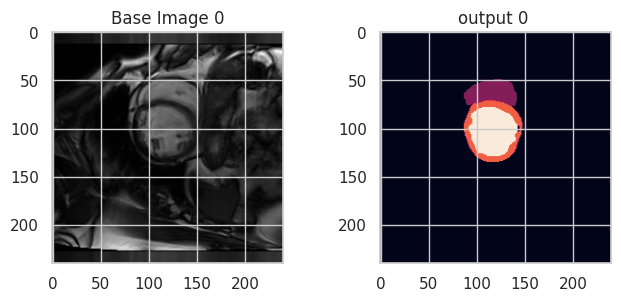

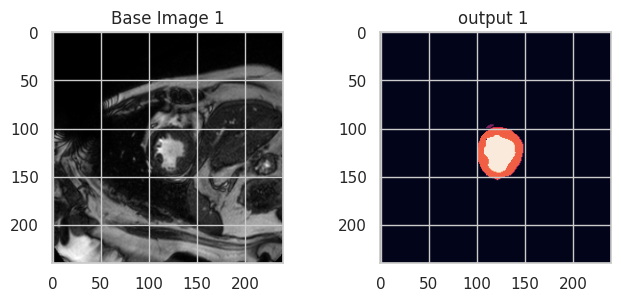

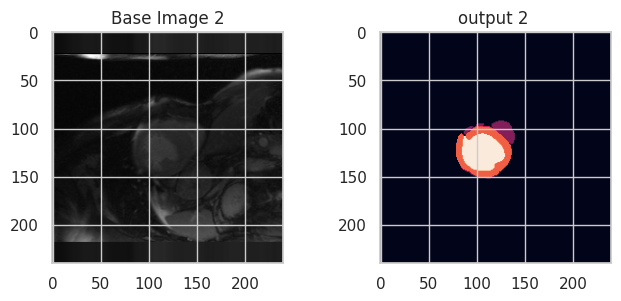

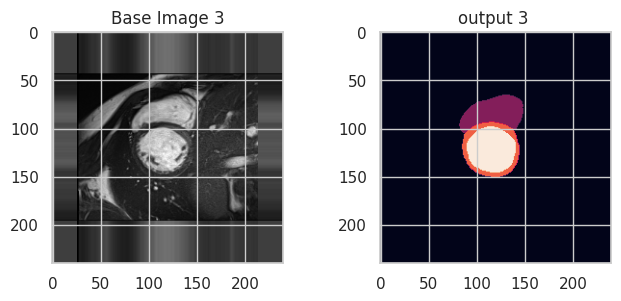

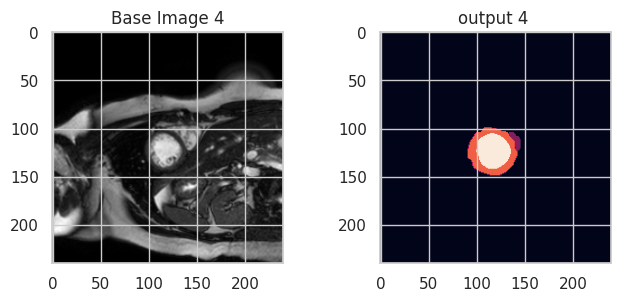

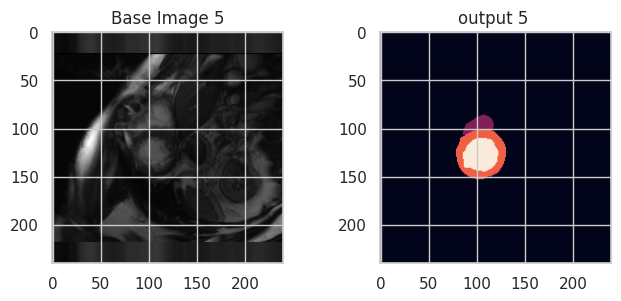

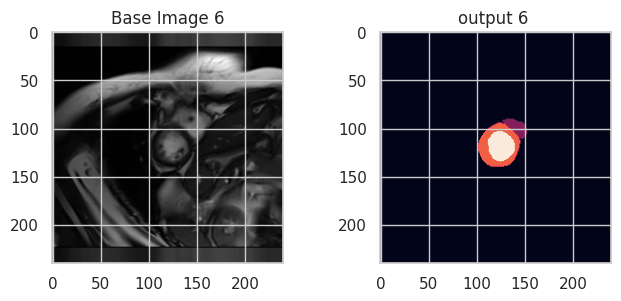

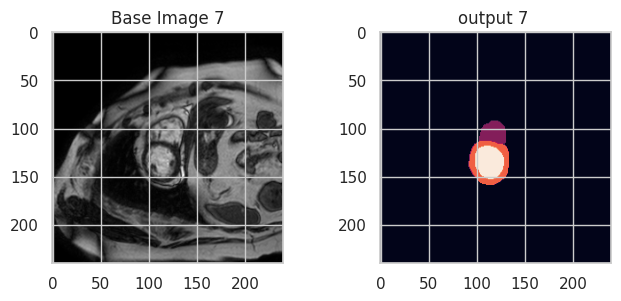

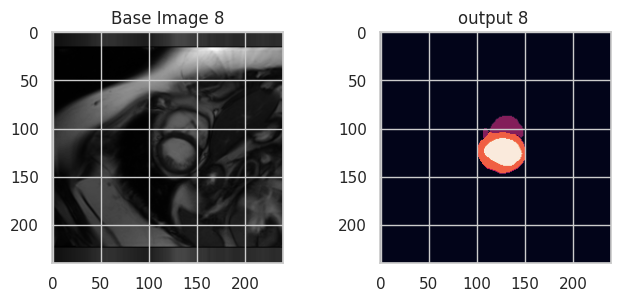

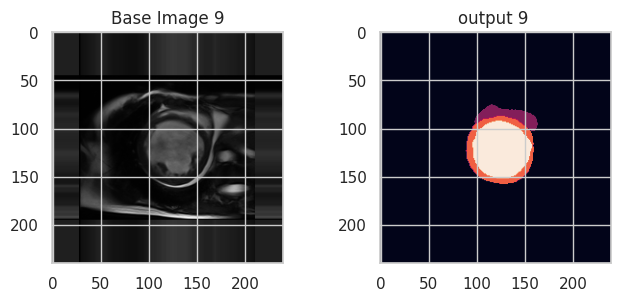

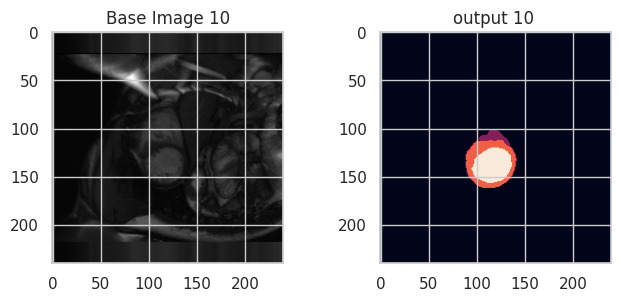

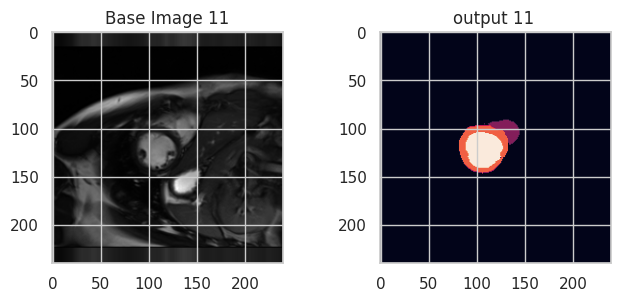

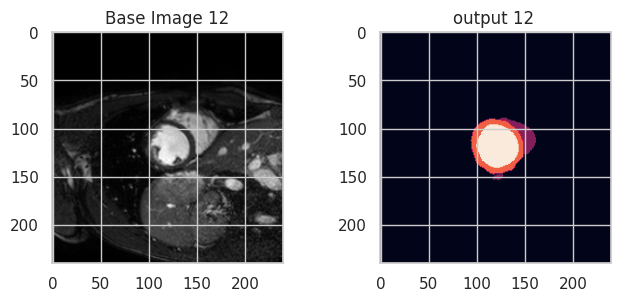

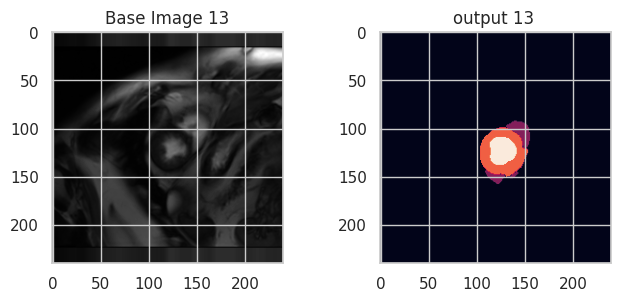

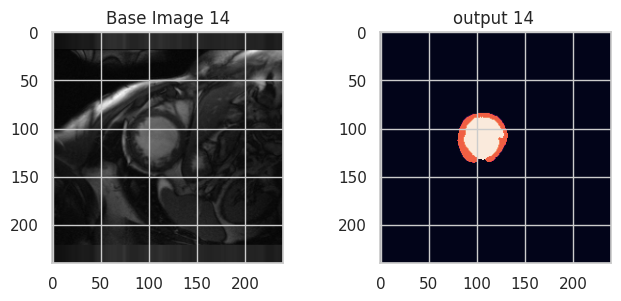

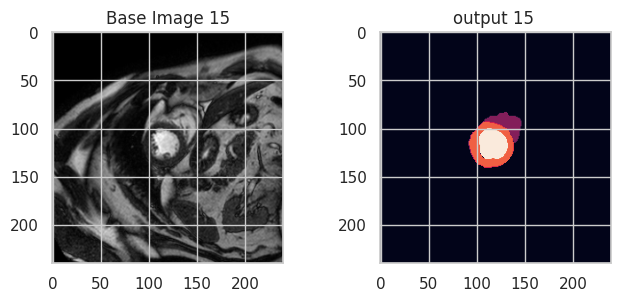

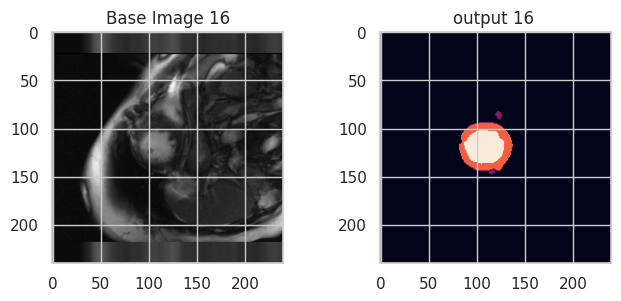

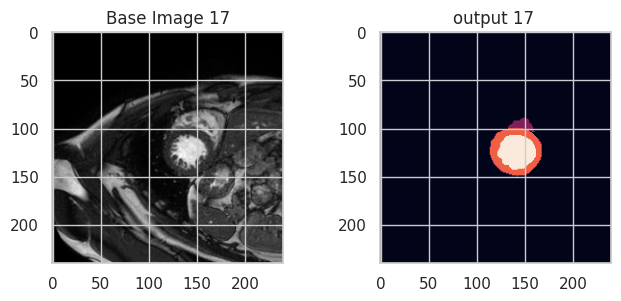

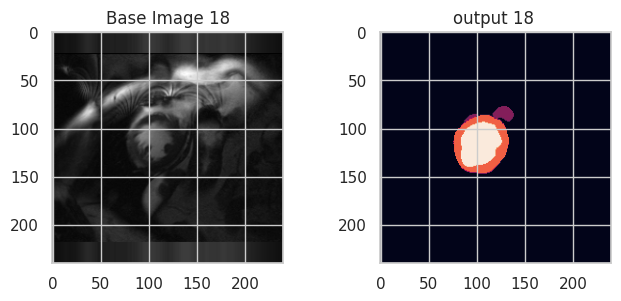

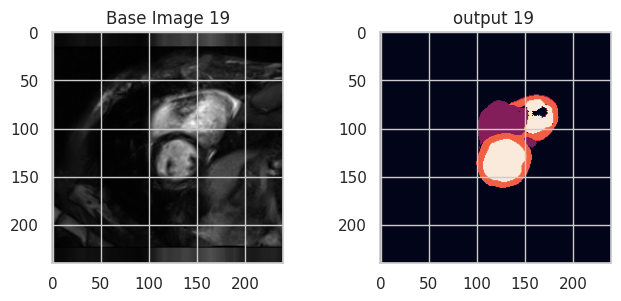

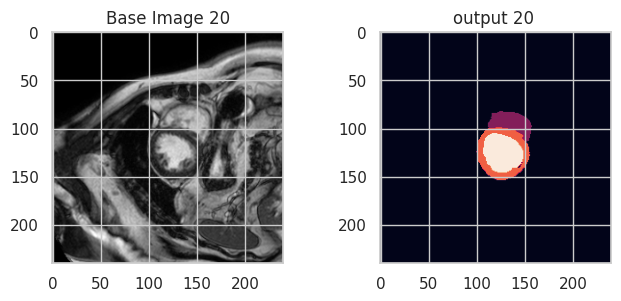

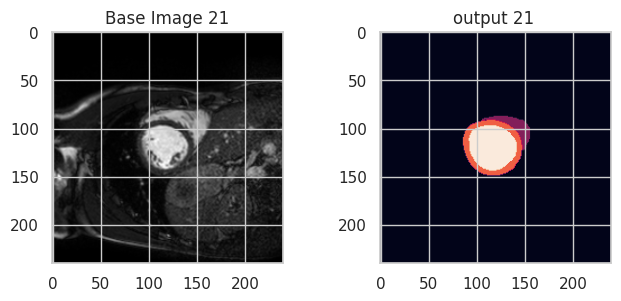

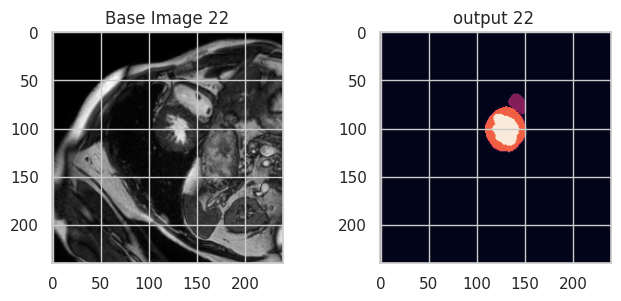

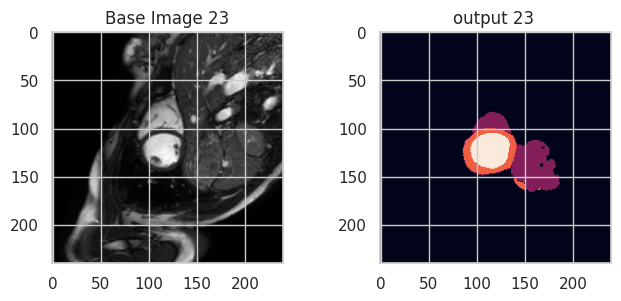

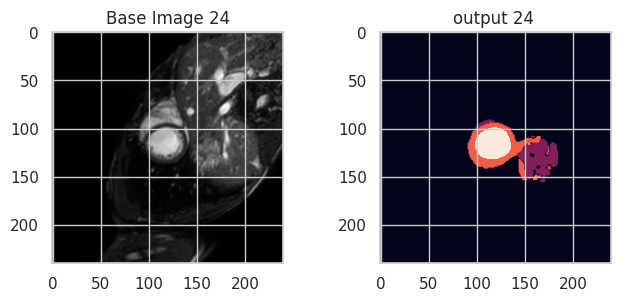

In [153]:
###
# Segment secret test set
###

post_save = post_pred
# post_save = Compose(
#     [
#         Invertd(
#             keys="pred",
#             transform=test_transforms,
#             orig_keys="image",
#             meta_keys="pred_meta_dict",
#             orig_meta_keys="image_meta_dict",
#             meta_key_postfix="meta_dict",
#             nearest_interp=False,
#             to_tensor=True,
#         ),
#         AsDiscreted(keys="pred", argmax=True, to_onehot=1),
#         SaveImaged(keys="pred", meta_keys="pred_meta_dict", output_dir="./out", output_postfix="seg", resample=False),
#     ]
# )


process_loader(secret_loader, model, post_save, post_label, loss_function, device, plot=True, sliding_window=False, plot_count=25)

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)